**Bengaluru House price prediction**





# Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# from google.colab import drive
# drive.flush_and_unmount()

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import warnings
import xgboost as xgb
import lightgbm as lgb
from scipy.stats import skew
from scipy import stats
from scipy.stats.stats import pearsonr
from scipy.stats import norm
from collections import Counter
from sklearn.linear_model import LinearRegression,LassoCV, Ridge, LassoLarsCV,ElasticNetCV
from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, Normalizer, RobustScaler
warnings.filterwarnings('ignore')
sns.set(style='white', context='notebook', palette='deep')
%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline


In [ ]:
import numpy as np
import pandas as pd
import string
import matplotlib.pyplot as plt
import seaborn as sns
import math

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.filterwarnings('ignore')

# Data Loads

In [ ]:
train_data=pd.read_csv("/content/drive/MyDrive/raw/train_data.csv")
test_data=pd.read_csv("/content/drive/MyDrive/raw/train_data.csv")

In [ ]:
train_data.head()

,s_no,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,1,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,2,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,3,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,4,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,5,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [ ]:
train_data.shape
test_data.shape

(13320, 10)

(13320, 10)

In [ ]:
# sns.distplot(train_data['price'] , fit=norm);

# # Get the fitted parameters used by the function
# (mu, sigma) = norm.fit(train_data['price'])
# print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
# plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
#             loc='best')
# plt.ylabel('Frequency')
# plt.title('SalePrice distribution')

# fig = plt.figure()
# res = stats.probplot(train_data['price'], plot=plt)
# plt.show()

# print("Skewness: %f" % train_data['price'].skew())
# print("Kurtosis: %f" % train_data['price'].kurt())

## Adding Train and Test Data

To apply the same set of data cleaning operations on Train and Test dataset, concatenating them both. Adding a column 'data_category' in both datasets with values 'train' and 'test' respectively. 


In [ ]:
train_data['data_category'] = 'train'
test_data['data_category'] = 'test'

In [ ]:
df = pd.concat([train_data,test_data], ignore_index=True)
df.drop(['s_no'], axis=1, inplace=True)

In [ ]:
df.shape
df.tail()

(26640, 10)

,area_type,availability,location,size,society,total_sqft,bath,balcony,price,data_category
26635,Built-up Area,Ready To Move,Whitefield,5 Bedroom,ArsiaEx,3453,4.0,0.0,231.0,test
26636,Super built-up Area,Ready To Move,Richards Town,4 BHK,NaN,3600,5.0,NaN,400.0,test
26637,Built-up Area,Ready To Move,Raja Rajeshwari Nagar,2 BHK,Mahla T,1141,2.0,1.0,60.0,test
26638,Super built-up Area,18-Jun,Padmanabhanagar,4 BHK,SollyCl,4689,4.0,1.0,488.0,test
26639,Super built-up Area,Ready To Move,Doddathoguru,1 BHK,NaN,550,1.0,1.0,17.0,test


# EDA

## Checking Null Values

In [ ]:
df.isnull().sum()

area_type            0
availability         0
location             2
size                32
society          11004
total_sqft           0
bath               146
balcony           1218
price                0
data_category        0
dtype: int64

<Figure size 1152x504 with 0 Axes>

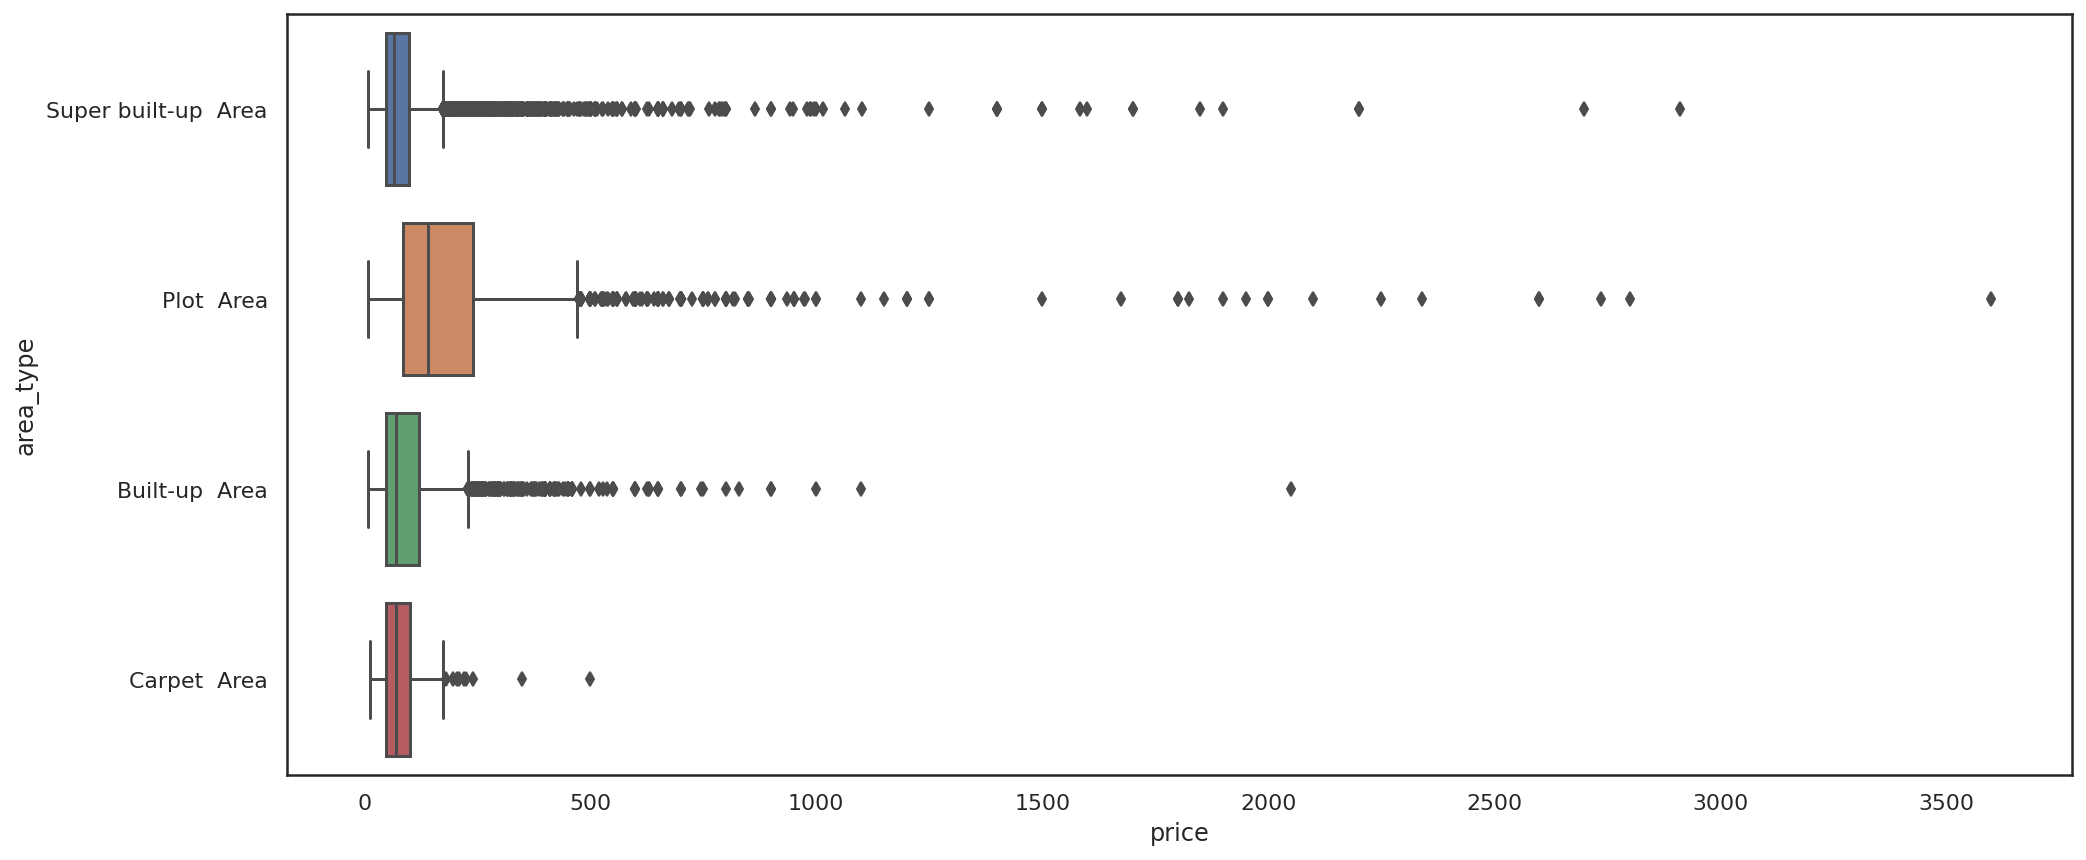

In [ ]:
plt.figure(figsize=(16,7))
sns.boxplot(x=train_data['price'],y=train_data['area_type'])

As expected, the median cost for 'Plot Area' house type is the highest among other categories.

In [ ]:
df.dtypes

area_type         object
availability      object
location          object
size              object
society           object
total_sqft        object
bath             float64
balcony          float64
price            float64
data_category     object
dtype: object

We can see that the two main columns 'size' and 'total_sqft' are objects instead of numeric. Hence, we cannot go further with EDA till we clean these columns. Let's do the cleaning and data exploration simultaneously. 

## Checking unique and number of unique values present in each categorical variable

In [ ]:
for i in df.columns:
    if df[i].dtype == 'O':
        print('\nNumber of unique values in {} category: '.format(i), df[i].nunique())
        print('Unique data in {} category:\n'.format(i), df[i].unique())


Number of unique values in area_type category:  4
Unique data in area_type category:
 ['Super built-up  Area' 'Plot  Area' 'Built-up  Area' 'Carpet  Area']

Number of unique values in availability category:  81
Unique data in availability category:
 ['19-Dec' 'Ready To Move' '18-May' '18-Feb' '18-Nov' '20-Dec' '17-Oct'
 '21-Dec' '19-Sep' '20-Sep' '18-Mar' '20-Feb' '18-Apr' '20-Aug' '18-Oct'
 '19-Mar' '17-Sep' '18-Dec' '17-Aug' '19-Apr' '18-Jun' '22-Dec' '22-Jan'
 '18-Aug' '19-Jan' '17-Jul' '18-Jul' '21-Jun' '20-May' '19-Aug' '18-Sep'
 '17-May' '17-Jun' '21-May' '18-Jan' '20-Mar' '17-Dec' '16-Mar' '19-Jun'
 '22-Jun' '19-Jul' '21-Feb' 'Immediate Possession' '19-May' '17-Nov'
 '20-Oct' '20-Jun' '19-Feb' '21-Oct' '21-Jan' '17-Mar' '17-Apr' '22-May'
 '19-Oct' '21-Jul' '21-Nov' '21-Mar' '16-Dec' '22-Mar' '20-Jan' '21-Sep'
 '21-Aug' '14-Nov' '19-Nov' '15-Nov' '16-Jul' '15-Jun' '17-Feb' '20-Nov'
 '20-Jul' '16-Sep' '15-Oct' '15-Dec' '16-Oct' '22-Nov' '15-Aug' '17-Jan'
 '16-Nov' '20-Apr' '16-Ja

# Data Cleaning and Feature Engineering

## Size - Number of Bedrooms

In [ ]:
df['size'].value_counts().head()

2 BHK        10398
3 BHK         8620
4 Bedroom     1652
4 BHK         1182
3 Bedroom     1094
Name: size, dtype: int64

Since, number of bedrooms should be a continuos variable, we'll only extract the numeric value from this series of string values.

In [ ]:
df['size'] = df['size'].apply(lambda x: x.split(' ')[0] if isinstance(x,str) else np.nan)
df['size'] = df['size'].astype(float)

In [ ]:
# corrmat = train_data.corr()
# f, ax = plt.subplots(figsize=(12, 9))
# sns.heatmap(corrmat, vmax=.8, square=True);

In [ ]:

# k = 5 #number of variables for heatmap
# cols = corrmat.nlargest(k, 'price')['price'].index
# cm = np.corrcoef(train_data[cols].values.T)
# sns.set(font_scale=1.25)
# hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
# plt.show()

In [ ]:
df['size'].isnull().sum()

32

## Location

In [ ]:
df['location'].value_counts()

Whitefield                            1080
Sarjapur  Road                         798
Electronic City                        604
Kanakpura Road                         546
Thanisandra                            468
                                      ... 
Kumbhena Agrahara                        2
Chikka Gowdanapalya.                     2
3rd Block HBR Layout                     2
1Hanuman Nagar                           2
Basvasamithi Layout Vidyaranyapura       2
Name: location, Length: 1305, dtype: int64

### Searching Location Pincode through Selenium Webdriver

In [ ]:
uniq_locn=pd.DataFrame(df['location'].unique(), columns=['location'])

In [ ]:
uniq_locn['browser_link'] = uniq_locn['location'].apply(lambda x: str(x) + " Bangalore site:codepin.in")

In [ ]:
!pip install selenium
!apt-get update 
!apt install chromium-chromedriver

Hit:1 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:9 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic 

In [ ]:
# import os
# from selenium import webdriver
# from selenium.webdriver.common.keys import Keys
# from selenium.webdriver.common.by import By
# from selenium.common.exceptions import NoSuchElementException, WebDriverException
# import requests

# # get the path of ChromeDriverServer
# dir = os.path.dirname(r"C:\Users\Devesh Singh\Python Scripts\Machine Hack\chromedriver.exe")
# chrome_driver_path = dir + "\chromedriver.exe"

# uniq_test = uniq_locn.copy(deep=True)

# final_list=pd.DataFrame({'Place':[],
#                          'Pin Code':[],
#                          'Taluk':[],
#                          'Division':[],
#                          'District':[],
#                          'State':[],
#                         'Uniq':[]})

# count=0
# m=0
# # create a new Chrome session
# driver = webdriver.Chrome(chrome_driver_path)
# driver.implicitly_wait(5)
# driver.maximize_window()

# for i in range(len(uniq_test)):
    
#     # Navigate to the application home page
#     driver.get("http://www.bing.com/")
    
#     # get the search textbox
#     #search_field = driver.find_element_by_name("q")    #worked, for Google.com only
#     search_field = driver.find_element_by_id("sb_form_q")    #worked, for Bing Search
    
#     # enter search keyword and submit
#     search_field.send_keys(uniq_test.iloc[i,0])
#     search_field.submit()
    
#     try:
#         #clicking the first link
#         #driver.find_element(By.XPATH, '(//h3)[1]/a').click()    #worked, for Google.com only
#         driver.find_element_by_partial_link_text("PIN CODE").click()   #worked, for Bing Search

#         #waiting for link to open fully
#         driver.implicitly_wait(5)

#         #copying the url of the browser
#         url = driver.current_url

#         html = requests.get(url).content
#         df_list = pd.read_html(html)


#         df = df_list[-1]
#         df2=pd.DataFrame(df.iloc[1,:])
#         df3=pd.DataFrame.transpose(df2).reset_index(drop=True)
#         value=pd.DataFrame({'Place':[df3.iloc[0,0]],
#                             'Pin Code':[df3.iloc[0,1]],
#                             'Taluk':[df3.iloc[0,2]],
#                             'Division':[df3.iloc[0,3]],
#                             'District':[df3.iloc[0,4]],
#                             'State':[df3.iloc[0,5]],
#                             'Uniq':[uniq_test.iloc[i,0]]})

#         final_list=final_list.append(value, ignore_index=True)
#         m+=1
#         print(m,"  ",uniq_test.iloc[i,0])
    
#     except (NoSuchElementException, WebDriverException) as e:
#         count += 1
#         pass
#     driver.delete_all_cookies()
    
# driver.close()

### Pincode File

Reading the dataframe of scraped pincodes.

In [ ]:
# Downloaded list of pincodes
location_df = pd.read_excel(r'/content/drive/MyDrive/raw/location_pincodes.xlsx')

In [ ]:
uniq_locn['pincode'] = (uniq_locn['browser_link']
                        .map(dict(zip(location_df['browser_link'],location_df['pincode']))))

In [ ]:
uniq_locn.head()

,location,browser_link,pincode
0,Electronic City Phase II,Electronic City Phase II Bangalore site:codepi...,560100
1,Chikka Tirupathi,Chikka Tirupathi Bangalore site:codepin.in,561203
2,Uttarahalli,Uttarahalli Bangalore site:codepin.in,560061
3,Lingadheeranahalli,Lingadheeranahalli Bangalore site:codepin.in,560091
4,Kothanur,Kothanur Bangalore site:codepin.in,560077


Mapping this list with original dataframe.

In [ ]:
df['location'] = df['location'].map(dict(zip(uniq_locn['location'],uniq_locn['pincode'])))

In [ ]:
df.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price,data_category
0,Super built-up Area,19-Dec,560100,2.0,Coomee,1056,2.0,1.0,39.07,train
1,Plot Area,Ready To Move,561203,4.0,Theanmp,2600,5.0,3.0,120.00,train
2,Built-up Area,Ready To Move,560061,3.0,NaN,1440,2.0,3.0,62.00,train
3,Super built-up Area,Ready To Move,560091,3.0,Soiewre,1521,3.0,1.0,95.00,train
4,Super built-up Area,Ready To Move,560077,2.0,NaN,1200,2.0,1.0,51.00,train


In [ ]:
df['location'].value_counts().head()

560100    1650
560066    1624
560078    1108
560077    1098
562125     880
Name: location, dtype: int64

In [ ]:
df['location'].isnull().sum()

0

## Total Square Feet

In [ ]:
df['total_sqft'].unique()

array(['1056', '2600', '1440', ..., '1133 - 1384', '774', '4689'],
      dtype=object)

In [ ]:
sqft = df[['total_sqft']]

In [ ]:
sqft.dtypes

total_sqft    object
dtype: object

### Extracting Only Float Val or Only String Val

Function to extract only float value, other values will be replaced as NaNs.

In [ ]:
def float_val(x):
    try:
        x = float(x)
    except:
        x = np.nan
    return x

Function to extract only string value, other values will be replaced as NaNs.

In [ ]:
def string_val(x):
    try:
        x = float(x)
        if isinstance(x,float):
            x = np.nan
    except:
        pass    
    return x

In [ ]:
sqft['float_val'] = sqft['total_sqft'].apply(float_val)

sqft['string_val'] = sqft['total_sqft'].apply(string_val)

sqft[sqft['string_val'].notnull()].head(10)

,total_sqft,float_val,string_val
30,2100 - 2850,NaN,2100 - 2850
56,3010 - 3410,NaN,3010 - 3410
81,2957 - 3450,NaN,2957 - 3450
122,3067 - 8156,NaN,3067 - 8156
137,1042 - 1105,NaN,1042 - 1105
165,1145 - 1340,NaN,1145 - 1340
188,1015 - 1540,NaN,1015 - 1540
224,1520 - 1740,NaN,1520 - 1740
410,34.46Sq. Meter,NaN,34.46Sq. Meter
549,1195 - 1440,NaN,1195 - 1440


### Processing String Vals

The errorneous string values present in the 'total_sqft' column are of two types:
- Range, e.g. 2100 - 2850, to clean this types of error, we are going to take the average of these ranges
- Values in other unit, e.g. 34.46Sq. Meter, to clean this, we are going to extract the float and string values, convert this values in square feet.

In [ ]:
sqft_string = sqft[['total_sqft','string_val']][sqft['string_val'].notnull()]

In [ ]:
sqft_string['v_1'] = sqft_string['string_val'].apply(lambda x: x.split("-")[0])
sqft_string['v_2'] = sqft_string['string_val'].apply(lambda x: x.split("-")[-1])

In [ ]:
def average_val(v_1, v_2):
    try:
        v_1 = float(v_1)
        v_2 = float(v_2)
        avg = (v_1 + v_2)/2
    except:
        avg = v_1
    return avg

In [ ]:
sqft_string['avg_val'] = sqft_string.apply(lambda x: average_val(x.v_1,x.v_2),axis=1 )
sqft_string.head()

,total_sqft,string_val,v_1,v_2,avg_val
30,2100 - 2850,2100 - 2850,2100,2850,2475
56,3010 - 3410,3010 - 3410,3010,3410,3210
81,2957 - 3450,2957 - 3450,2957,3450,3203.5
122,3067 - 8156,3067 - 8156,3067,8156,5611.5
137,1042 - 1105,1042 - 1105,1042,1105,1073.5


In [ ]:
sqft_string['conversion'] = sqft_string['avg_val'].apply(string_val)

sqft_string.head(10)

,total_sqft,string_val,v_1,v_2,avg_val,conversion
30,2100 - 2850,2100 - 2850,2100,2850,2475,NaN
56,3010 - 3410,3010 - 3410,3010,3410,3210,NaN
81,2957 - 3450,2957 - 3450,2957,3450,3203.5,NaN
122,3067 - 8156,3067 - 8156,3067,8156,5611.5,NaN
137,1042 - 1105,1042 - 1105,1042,1105,1073.5,NaN
165,1145 - 1340,1145 - 1340,1145,1340,1242.5,NaN
188,1015 - 1540,1015 - 1540,1015,1540,1277.5,NaN
224,1520 - 1740,1520 - 1740,1520,1740,1630,NaN
410,34.46Sq. Meter,34.46Sq. Meter,34.46Sq. Meter,34.46Sq. Meter,34.46Sq. Meter,34.46Sq. Meter
549,1195 - 1440,1195 - 1440,1195,1440,1317.5,NaN


### Extracting Conversion Units with 'Re'

In [ ]:
import re
sqft_string['con_val'] = sqft_string['conversion'].apply(lambda x: "".join(re.findall(r"[a-zA-Z_]", str(x))))

sqft_string['num_val'] = sqft_string['conversion'].apply(lambda x: ".".join(re.findall("\d+", str(x))))

In [ ]:
sqft_string.head(13)

,total_sqft,string_val,v_1,v_2,avg_val,conversion,con_val,num_val
30,2100 - 2850,2100 - 2850,2100,2850,2475,NaN,nan,
56,3010 - 3410,3010 - 3410,3010,3410,3210,NaN,nan,
81,2957 - 3450,2957 - 3450,2957,3450,3203.5,NaN,nan,
122,3067 - 8156,3067 - 8156,3067,8156,5611.5,NaN,nan,
137,1042 - 1105,1042 - 1105,1042,1105,1073.5,NaN,nan,
165,1145 - 1340,1145 - 1340,1145,1340,1242.5,NaN,nan,
188,1015 - 1540,1015 - 1540,1015,1540,1277.5,NaN,nan,
224,1520 - 1740,1520 - 1740,1520,1740,1630,NaN,nan,
410,34.46Sq. Meter,34.46Sq. Meter,34.46Sq. Meter,34.46Sq. Meter,34.46Sq. Meter,34.46Sq. Meter,SqMeter,34.46
549,1195 - 1440,1195 - 1440,1195,1440,1317.5,NaN,nan,


In [ ]:
sqft_string['num_val'] = sqft_string['num_val'].replace('', np.nan).fillna(0).astype(float)

In [ ]:
sqft_string['num_val'] = np.where(sqft_string['num_val'] == 0,
                                  sqft_string['avg_val'],
                                  sqft_string['num_val'])

In [ ]:
sqft_string.head(14)

,total_sqft,string_val,v_1,v_2,avg_val,conversion,con_val,num_val
30,2100 - 2850,2100 - 2850,2100,2850,2475,NaN,nan,2475
56,3010 - 3410,3010 - 3410,3010,3410,3210,NaN,nan,3210
81,2957 - 3450,2957 - 3450,2957,3450,3203.5,NaN,nan,3203.5
122,3067 - 8156,3067 - 8156,3067,8156,5611.5,NaN,nan,5611.5
137,1042 - 1105,1042 - 1105,1042,1105,1073.5,NaN,nan,1073.5
165,1145 - 1340,1145 - 1340,1145,1340,1242.5,NaN,nan,1242.5
188,1015 - 1540,1015 - 1540,1015,1540,1277.5,NaN,nan,1277.5
224,1520 - 1740,1520 - 1740,1520,1740,1630,NaN,nan,1630
410,34.46Sq. Meter,34.46Sq. Meter,34.46Sq. Meter,34.46Sq. Meter,34.46Sq. Meter,34.46Sq. Meter,SqMeter,34.46
549,1195 - 1440,1195 - 1440,1195,1440,1317.5,NaN,nan,1317.5


### Loading Conversion Factor

In [ ]:
# The list of conversion factor
conversion_factor = pd.read_csv(r"/content/drive/MyDrive/raw/conversion_factor.csv")

In [ ]:
conversion_factor

,unit,conversion_factor
0,Acres,43560.0000
1,SqMeter,10.7639
2,SqYards,9.0000
3,Cents,435.6000
4,Grounds,2400.0000
5,Guntha,1089.0000
6,Perch,272.2500


In [ ]:
sqft_string['conversion_factor'] = (sqft_string['con_val']
                                           .map(dict(zip(conversion_factor['unit']
                                                         ,conversion_factor['conversion_factor']))).fillna(1))

In [ ]:
sqft_string['after_conversion'] = sqft_string['num_val']*sqft_string['conversion_factor']

sqft_string['after_conversion'] = sqft_string['after_conversion'].apply(lambda x: round(x, 2))

sqft_string.head(10)

,total_sqft,string_val,v_1,v_2,avg_val,conversion,con_val,num_val,conversion_factor,after_conversion
30,2100 - 2850,2100 - 2850,2100,2850,2475,NaN,nan,2475,1.0000,2475.00
56,3010 - 3410,3010 - 3410,3010,3410,3210,NaN,nan,3210,1.0000,3210.00
81,2957 - 3450,2957 - 3450,2957,3450,3203.5,NaN,nan,3203.5,1.0000,3203.50
122,3067 - 8156,3067 - 8156,3067,8156,5611.5,NaN,nan,5611.5,1.0000,5611.50
137,1042 - 1105,1042 - 1105,1042,1105,1073.5,NaN,nan,1073.5,1.0000,1073.50
165,1145 - 1340,1145 - 1340,1145,1340,1242.5,NaN,nan,1242.5,1.0000,1242.50
188,1015 - 1540,1015 - 1540,1015,1540,1277.5,NaN,nan,1277.5,1.0000,1277.50
224,1520 - 1740,1520 - 1740,1520,1740,1630,NaN,nan,1630,1.0000,1630.00
410,34.46Sq. Meter,34.46Sq. Meter,34.46Sq. Meter,34.46Sq. Meter,34.46Sq. Meter,34.46Sq. Meter,SqMeter,34.46,10.7639,370.92
549,1195 - 1440,1195 - 1440,1195,1440,1317.5,NaN,nan,1317.5,1.0000,1317.50


In [ ]:
string_val_dict = dict(zip(sqft_string['total_sqft'],sqft_string['after_conversion']))

### Mapping Converted Rates with Original DF

In [ ]:
df['total_sqft_new'] = df['total_sqft'].map(string_val_dict)

In [ ]:
df['total_sqft'] = (df.apply(lambda row: row['total_sqft'] 
                             if np.isnan(row['total_sqft_new']) 
                             else row['total_sqft_new'],axis=1))

In [ ]:
df['total_sqft'] = df['total_sqft'].astype(float)

df.drop(['total_sqft_new'], axis=1, inplace=True)

In [ ]:
df['total_sqft'].isnull().sum()

0

## Society

In [ ]:
df['society'].isnull().sum()

11004

In [ ]:
df[df['society'].isnull()].head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price,data_category
2,Built-up Area,Ready To Move,560061,3.0,NaN,1440.0,2.0,3.0,62.00,train
4,Super built-up Area,Ready To Move,560077,2.0,NaN,1200.0,2.0,1.0,51.00,train
8,Super built-up Area,Ready To Move,560037,3.0,NaN,1310.0,3.0,1.0,63.25,train
9,Plot Area,Ready To Move,560004,6.0,NaN,1020.0,6.0,NaN,370.00,train
10,Super built-up Area,18-Feb,560066,3.0,NaN,1800.0,2.0,2.0,70.00,train


Here, just making a binary classification whether the House is in a Society or not, filling NaNs with zero and remaining with 1.

In [ ]:
df.loc[(df['society'].isnull()), 'society']= 0

df.loc[(df['society']!=0),'society'] = 1

df['society'].value_counts()

1    15636
0    11004
Name: society, dtype: int64

## Availability

In [ ]:
df['availability'].value_counts().head()

Ready To Move    21162
18-Dec             614
18-May             590
18-Apr             542
18-Aug             400
Name: availability, dtype: int64

In 'availability' column, we can broadly categorised the data into two ways:
- "Ready To Move" or "Immediate Possession"
- A future date

Since, the year is not mentioned in these dates, hence we cannot utilise this column further.
Therefore, categorising the data points as '1' for "Ready To Move" or "Immediate Possession" and 
'0' for the dates.

In [ ]:
df['availability'].replace(["Ready To Move","Immediate Possession"], 1, inplace=True)

df.loc[(df['availability']!=1),'availability'] = 0

df['availability'].value_counts()

1    21194
0     5446
Name: availability, dtype: int64

# Imputation

In [ ]:
df.isnull().sum()

area_type           0
availability        0
location            0
size               32
society             0
total_sqft          0
bath              146
balcony          1218
price               0
data_category       0
dtype: int64

## Size

In [ ]:
df[df['size'].isna()].head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price,data_category
579,Plot Area,1,562125,NaN,1,1800.0,NaN,NaN,34.185,train
1775,Plot Area,1,562110,NaN,1,3817.0,NaN,NaN,124.000,train
2264,Plot Area,1,560050,NaN,0,2400.0,NaN,NaN,460.000,train
2809,Plot Area,1,562125,NaN,1,1800.0,NaN,NaN,28.785,train
2862,Plot Area,1,562110,NaN,1,1950.0,NaN,NaN,46.800,train


To impute variable 'size' i.e. number of bedrooms, the variable 'total_sqft' is used. The 'total_sqft' is divided by 550(considering a generic factor per room in a house with hall and kitchen), and the roundup till the next integer.

In [ ]:
df['size'] = df['size'].astype(float)

In [ ]:
df['size'] = df.apply(lambda row: math.ceil(float(row['total_sqft']/550)) if np.isnan(row['size']) else row['size'], axis=1)

In [ ]:
df[df['size'].isna()]

,area_type,availability,location,size,society,total_sqft,bath,balcony,price,data_category


## Bath

In [ ]:
df[df['bath'].isna()].head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price,data_category
56,Built-up Area,0,562110,4.0,1,3210.0,NaN,NaN,192.000,train
81,Built-up Area,0,560077,4.0,1,3203.5,NaN,NaN,224.500,train
224,Super built-up Area,0,562110,3.0,1,1630.0,NaN,NaN,74.820,train
344,Super built-up Area,0,560062,1.0,1,525.0,NaN,NaN,21.530,train
579,Plot Area,1,562125,4.0,1,1800.0,NaN,NaN,34.185,train


In [ ]:
df[['size','bath']].corr()

,size,bath
size,1.000000,0.898408
bath,0.898408,1.000000


As we can see that number of bedrooms and bathrooms are highly correlated, we will fill the NaNs in variable 'bath' with values of variable 'size'.

In [ ]:
df['bath'] = df.apply(lambda row: row['size'] if np.isnan(row['bath']) else row['bath'], axis=1)

## Balcony

In [ ]:
df.groupby(['size']).agg({'balcony':['count','mean','median']})

balcony                 
       count      mean median
size                         
1.0     1296  0.773148    1.0
2.0    10960  1.431204    1.0
3.0     9312  1.823454    2.0
4.0     2476  1.697092    2.0
5.0      598  1.638796    2.0
6.0      384  1.812500    2.0
7.0      170  1.976471    2.0
8.0      136  1.705882    2.0
9.0       68  1.911765    2.0
10.0       6  3.000000    3.0
11.0       6  2.000000    3.0
12.0       2  2.000000    2.0
13.0       2  0.000000    0.0
14.0       2  0.000000    0.0
16.0       0       NaN    NaN
18.0       0       NaN    NaN
19.0       0       NaN    NaN
27.0       2  0.000000    0.0
43.0       2  0.000000    0.0

In [ ]:
balcony = df.groupby(['size']).agg({'balcony':'median'}).reset_index()

balcony['balcony'].fillna(4, inplace=True)

balcony_dict = dict(zip(balcony['size'], balcony['balcony']))

df['new_balcony'] = df[df['balcony'].isna()]['size'].map(balcony_dict)

In [ ]:
df['balcony'] = (df.apply(lambda row: row['new_balcony'] 
                          if np.isnan(row['balcony']) 
                          else row['balcony'], axis=1))

In [ ]:
df.drop(['new_balcony'], axis=1, inplace=True)

In [ ]:
df['balcony'].isnull().sum()

0

# Outlier Removal

In [ ]:
train_df = df[df['data_category']=='train']
test_df = df[df['data_category']=='test']

<Figure size 2160x720 with 0 Axes>

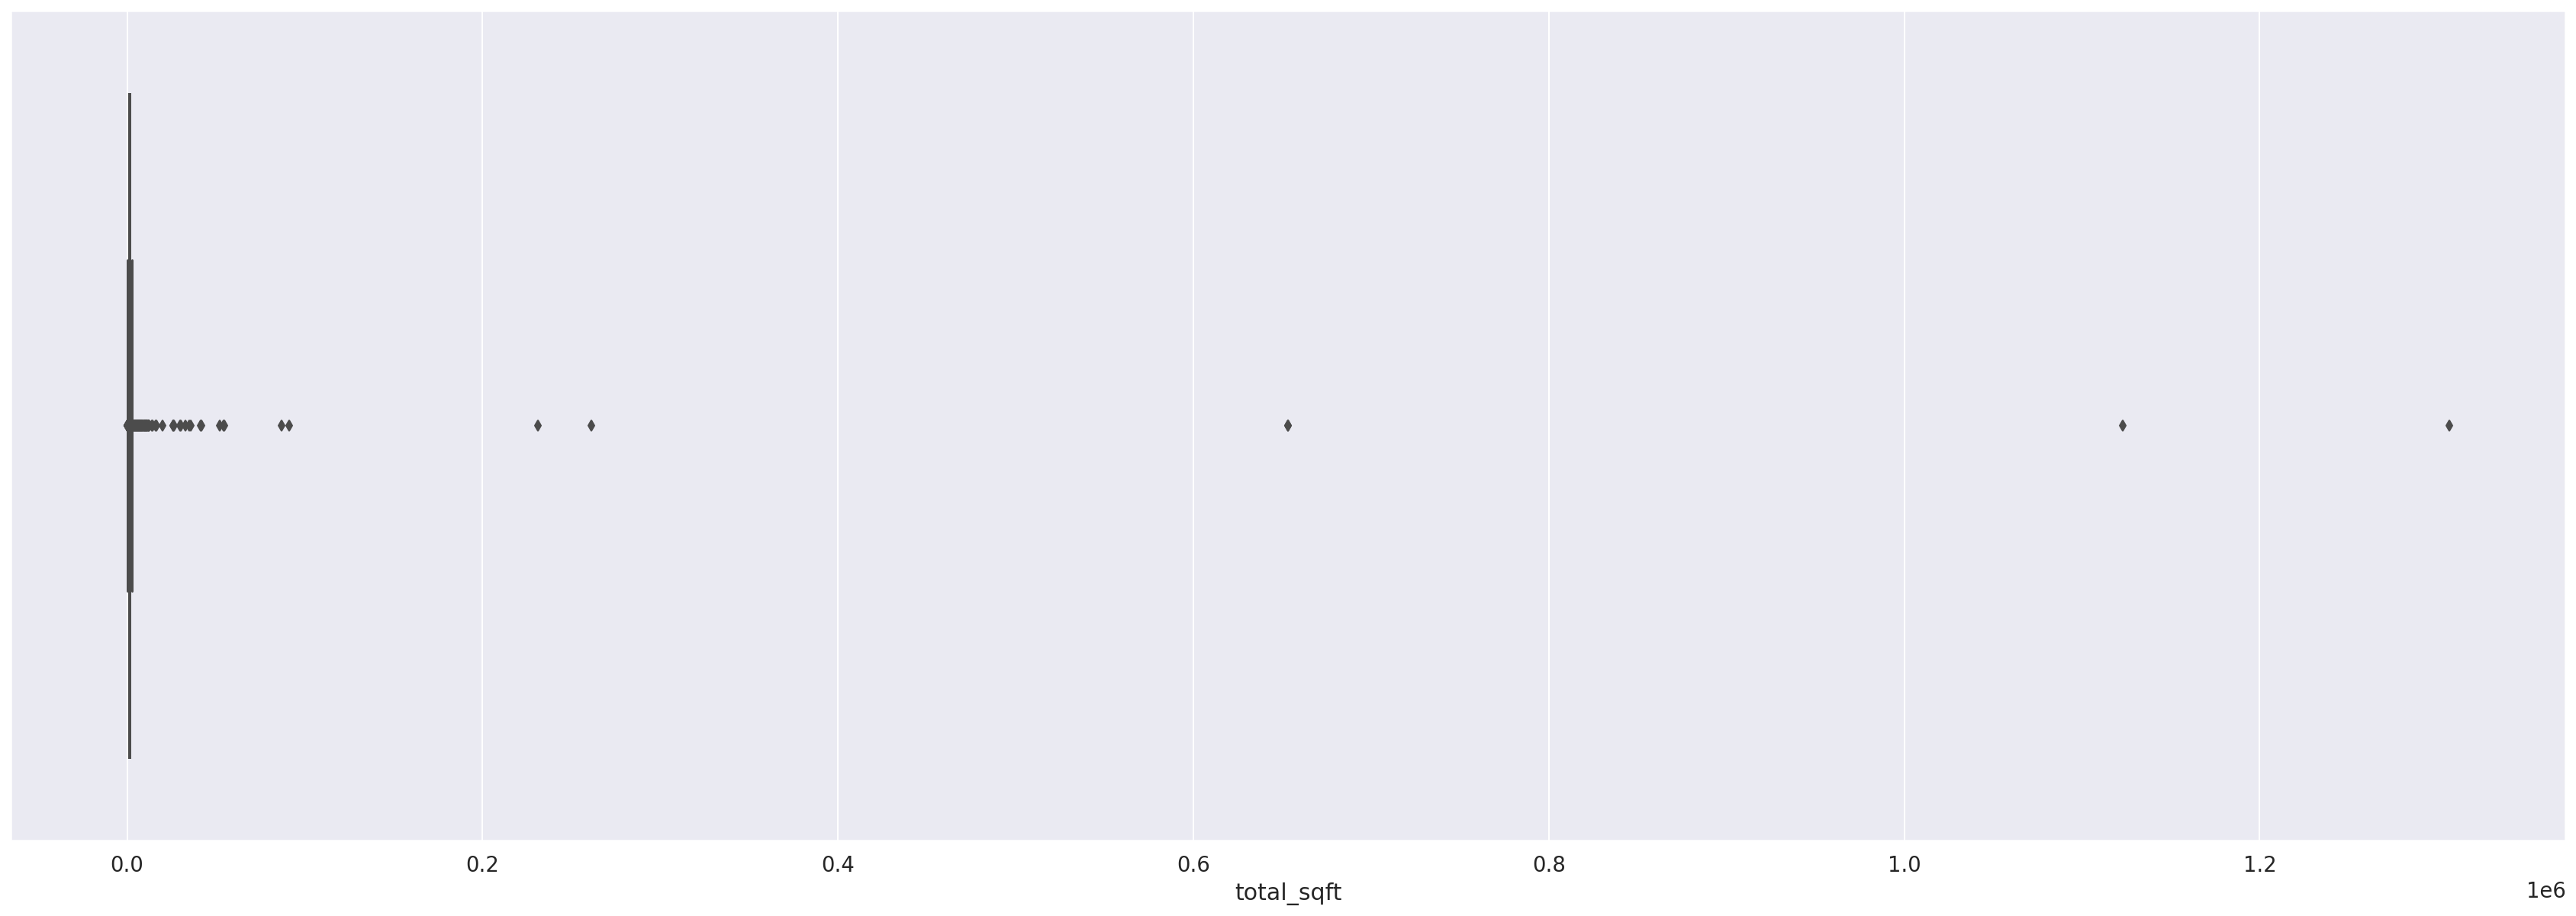

In [ ]:
plt.figure(figsize=(30,10))
sns.boxplot(train_df['total_sqft'])
plt.show()

In [ ]:
lower_limit = np.nanpercentile(train_df['total_sqft'],0.25)
upper_limit = np.nanpercentile(train_df['total_sqft'],99.75)
print(lower_limit)
print(upper_limit)

400.0
11000.0


In [ ]:
len(train_df)

13320

In [ ]:
train_df = train_df[train_df['total_sqft'].between(lower_limit, upper_limit)]

In [ ]:
len(train_df)

13256

So, we have removed 64 data points from training dataset.

In [ ]:
df = pd.concat([train_df,test_df])

# Deriving New Feature

## Price Per Location - Combining Location, Society and Area Type

In [ ]:
price_per_loc = (df[df['data_category']=='train'].groupby(['area_type','location','society'])
                 .agg({'total_sqft': 'sum','price':'sum'}).reset_index())

price_per_loc['avg_price_per_loc'] = price_per_loc['price']/price_per_loc['total_sqft']

In [ ]:
price_per_loc.head()

,area_type,location,society,total_sqft,price,avg_price_per_loc
0,Built-up Area,0,0,3420.0,410.0,0.119883
1,Built-up Area,0,1,1130.0,68.0,0.060177
2,Built-up Area,560001,0,4970.0,515.0,0.103622
3,Built-up Area,560001,1,1000.0,50.0,0.050000
4,Built-up Area,560003,0,11300.0,2410.0,0.213274


Merging this new column with original 'df'.

In [ ]:
df = pd.merge(df,price_per_loc[['area_type','location', 'society','avg_price_per_loc']],
                  on=['area_type','location', 'society'], how='left')

In [ ]:
df['avg_price_per_loc'].isnull().sum()

3

## Price Per Location 2 - Combining Location and Society Only 

In [ ]:
price_per_loc_2 = (df[df['data_category']=='train'].groupby(['location','society'])
                   .agg({'total_sqft': 'sum','price':'sum'}).reset_index())

price_per_loc_2['avg_price_per_loc_2'] = price_per_loc_2['price']/price_per_loc_2['total_sqft']

In [ ]:
price_per_loc_2.head()

,location,society,total_sqft,price,avg_price_per_loc_2
0,0,0,16173.82,1774.84,0.109735
1,0,1,4734.00,229.00,0.048373
2,560001,0,32275.00,5385.00,0.166847
3,560001,1,8914.00,1610.00,0.180615
4,560003,0,54775.00,10588.80,0.193314


In [ ]:
df = pd.merge(df,price_per_loc_2[['location', 'society','avg_price_per_loc_2']],
                  on=['location', 'society'], how='left')

In [ ]:
df['avg_price_per_loc'] = df.apply(lambda row: row['avg_price_per_loc_2'] if np.isnan(row['avg_price_per_loc']) else row['avg_price_per_loc'], axis=1)

In [ ]:
df['avg_price_per_loc'].isnull().sum()

2

## Price Per Location 3 - Average Price per SqFt for remaining null values

There are still three values we need to fill.

In [ ]:
average_price = df[df['data_category']=='train']['price'].sum()/df[df['data_category']=='train']['total_sqft'].sum()

In [ ]:
df['avg_price_per_loc'].fillna(average_price, inplace=True)

<Figure size 2160x720 with 0 Axes>

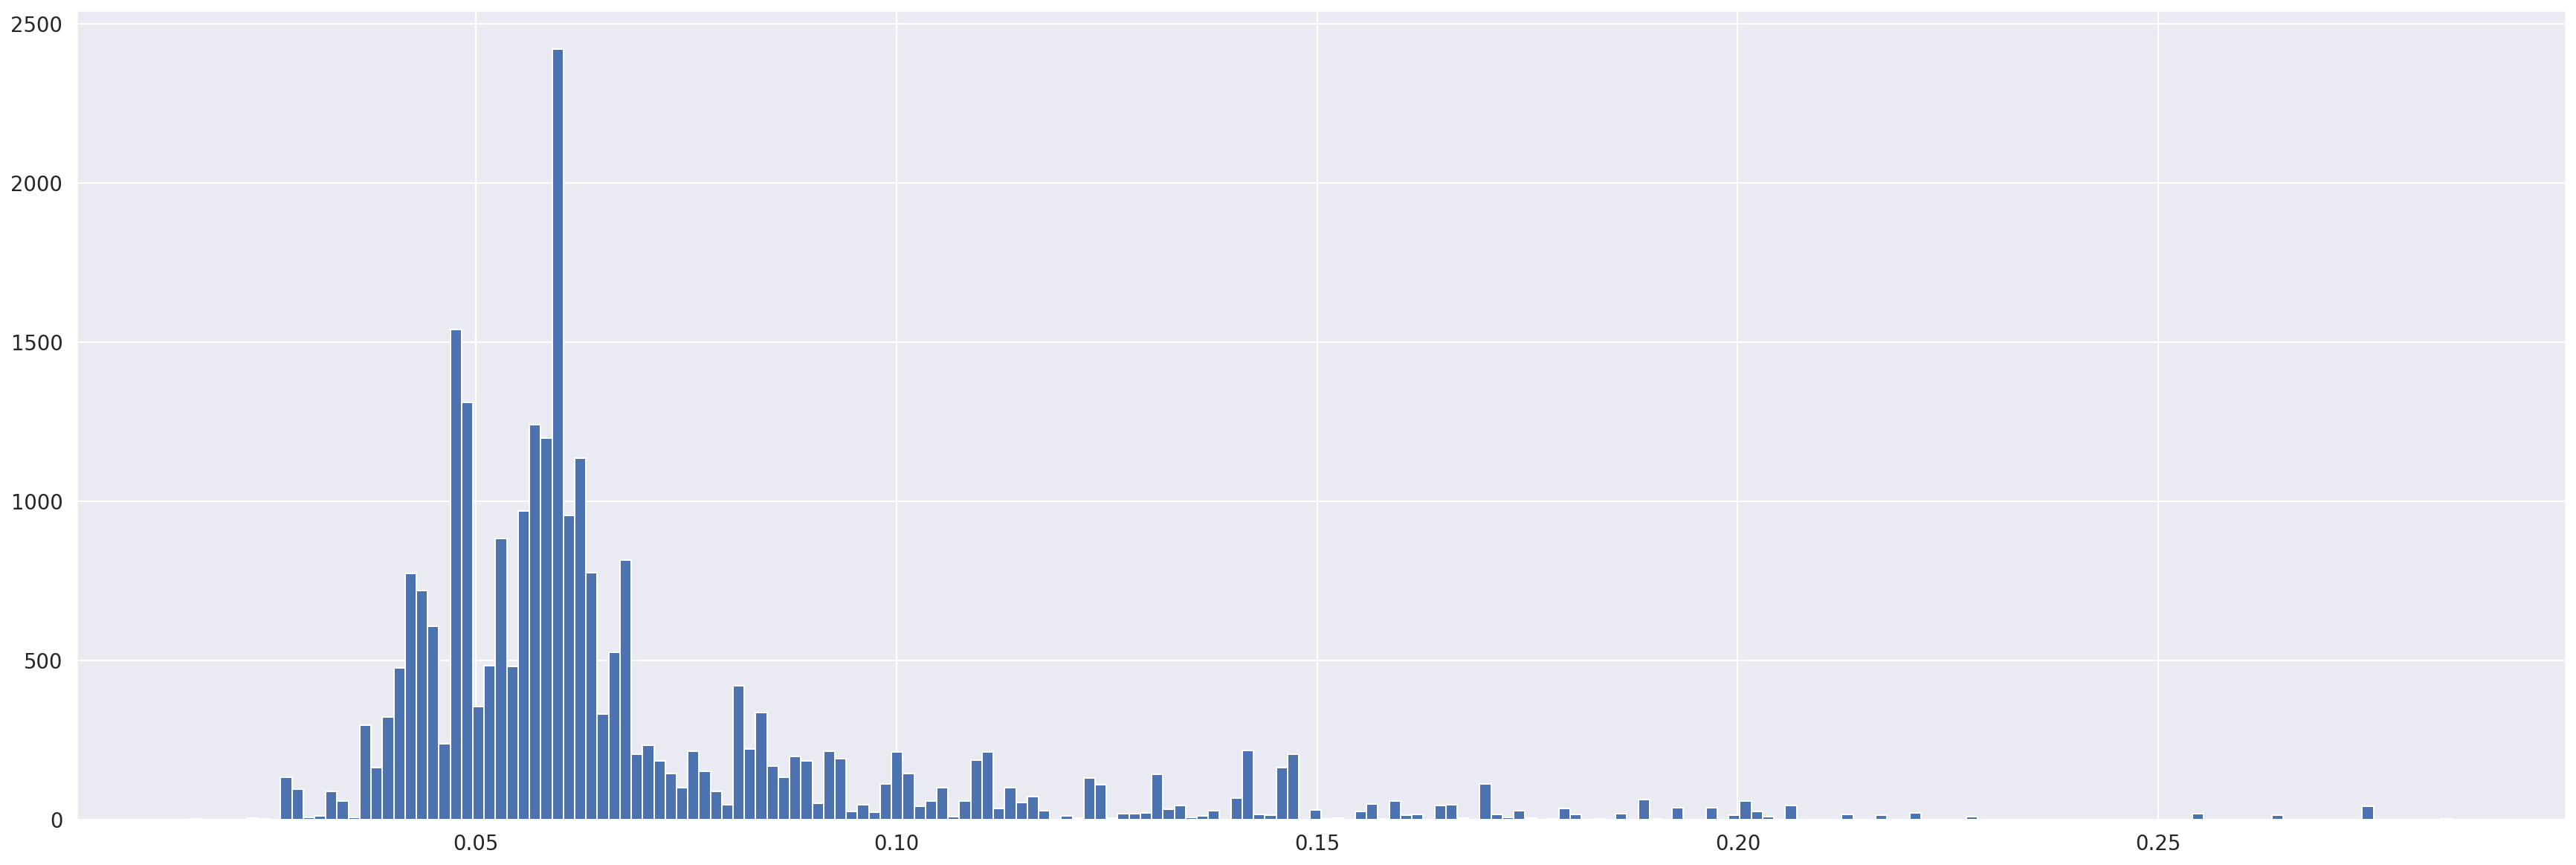

In [ ]:
plt.figure(figsize=(30,10))
df['avg_price_per_loc'].hist(bins=200)
plt.show()

In [ ]:
df.drop(['location','avg_price_per_loc_2'],axis=1, inplace=True)

In [ ]:
df.head(5)

,area_type,availability,size,society,total_sqft,bath,balcony,price,data_category,avg_price_per_loc
0,Super built-up Area,0,2.0,1,1056.0,2.0,1.0,39.07,train,0.047765
1,Plot Area,1,4.0,1,2600.0,5.0,3.0,120.00,train,0.047257
2,Built-up Area,1,3.0,0,1440.0,2.0,3.0,62.00,train,0.048929
3,Super built-up Area,1,3.0,1,1521.0,3.0,1.0,95.00,train,0.075807
4,Super built-up Area,1,2.0,0,1200.0,2.0,1.0,51.00,train,0.048198


Finally we have got a new feature which is created from variable 'location'.

# Checking the Distribution

## Specifying data type to each variable

In [ ]:
df['area_type'] = pd.Categorical(df['area_type'])
df[['size','total_sqft','bath','balcony','avg_price_per_loc','price']] = df[['size','total_sqft','bath','balcony','avg_price_per_loc','price']].apply(pd.to_numeric)

df[['availability','society']]  = df[['availability','society']].astype(int)

In [ ]:
df = df[['area_type', 'availability', 'size', 'society', 'total_sqft', 'bath',
       'balcony', 'avg_price_per_loc', 'price', 'data_category']]

In [ ]:
df.head()

,area_type,availability,size,society,total_sqft,bath,balcony,avg_price_per_loc,price,data_category
0,Super built-up Area,0,2.0,1,1056.0,2.0,1.0,0.047765,39.07,train
1,Plot Area,1,4.0,1,2600.0,5.0,3.0,0.047257,120.00,train
2,Built-up Area,1,3.0,0,1440.0,2.0,3.0,0.048929,62.00,train
3,Super built-up Area,1,3.0,1,1521.0,3.0,1.0,0.075807,95.00,train
4,Super built-up Area,1,2.0,0,1200.0,2.0,1.0,0.048198,51.00,train


## Total Sqft

<Figure size 2160x720 with 0 Axes>

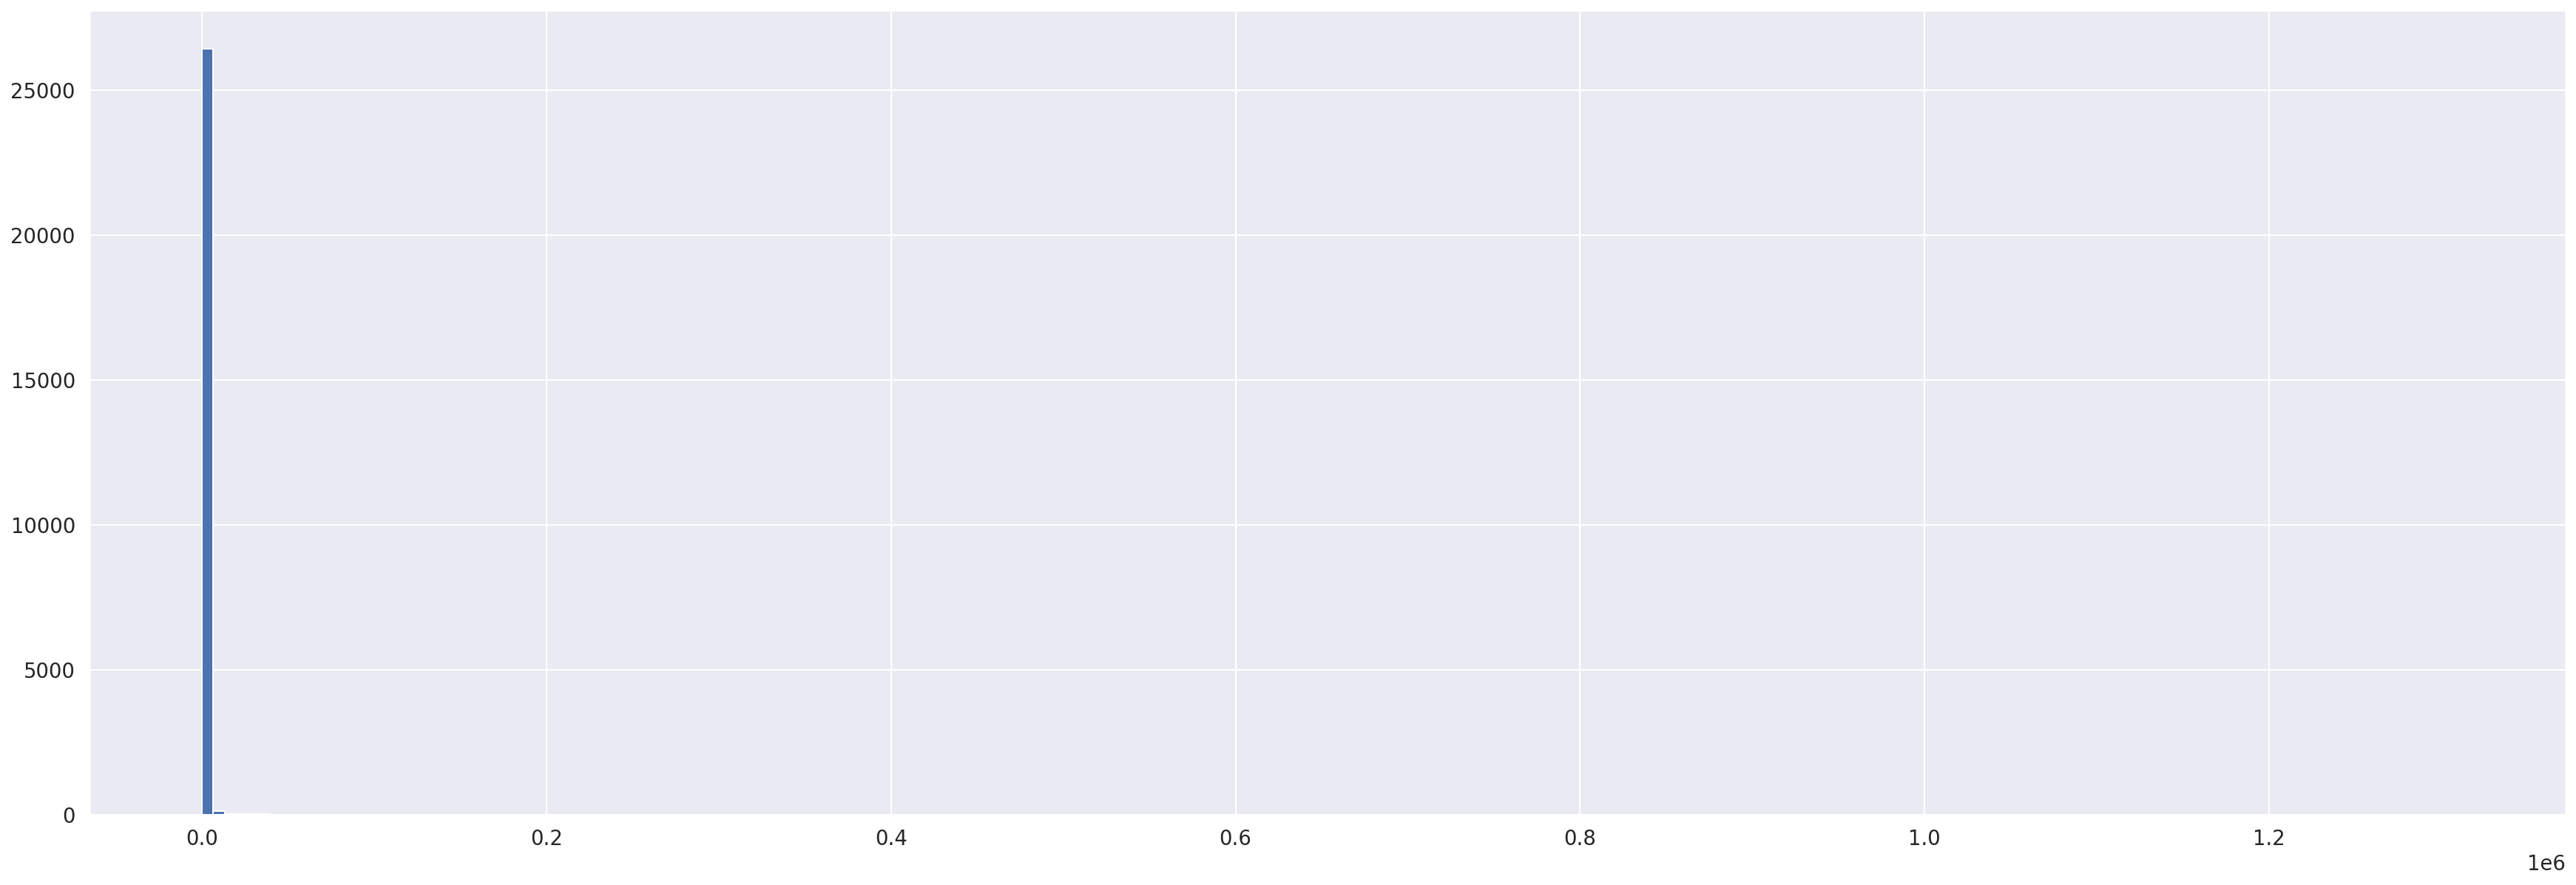

In [ ]:
plt.figure(figsize=(30,10))
df['total_sqft'].hist(bins=200)
plt.show()

The distribution is right skewed. Let's see if taking logrithmic value can remove this skewness.

<Figure size 2160x720 with 0 Axes>

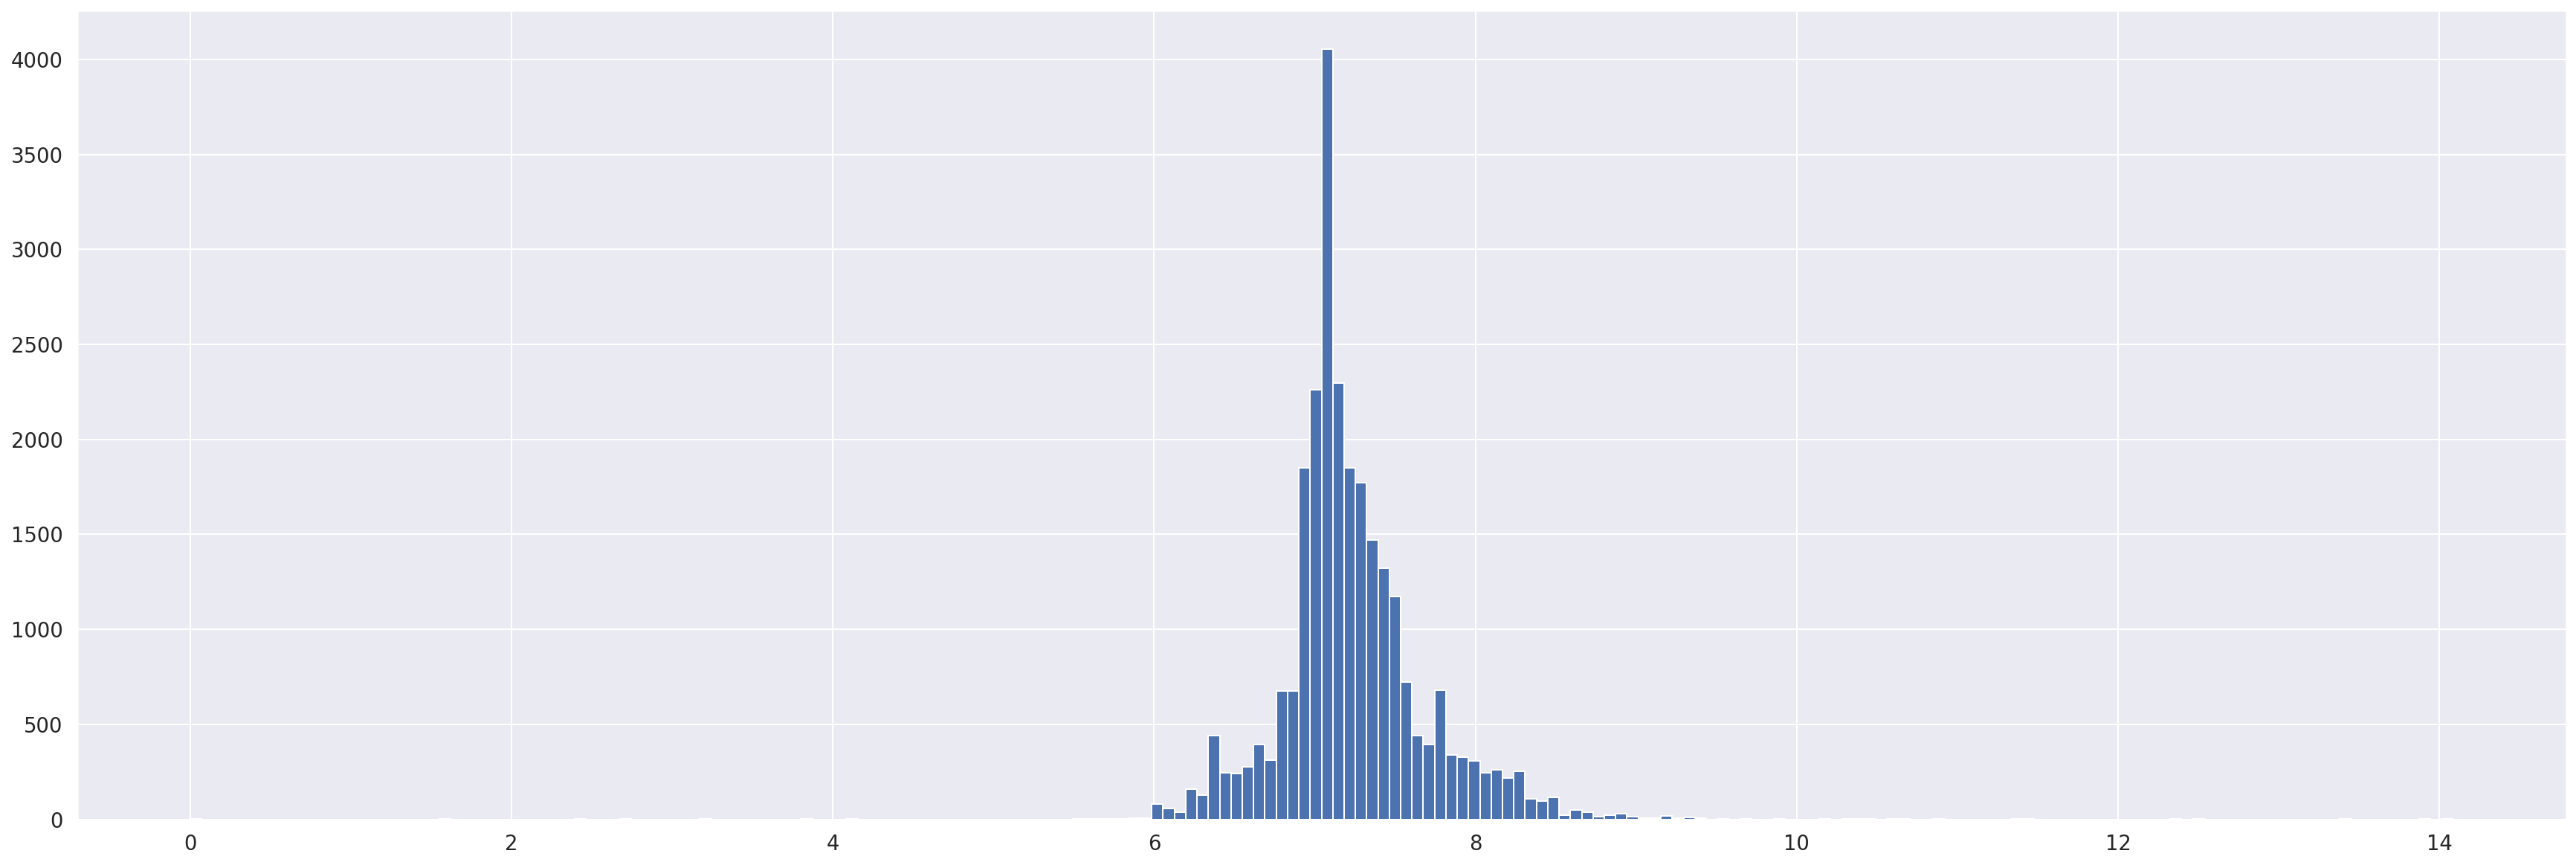

In [ ]:
plt.figure(figsize=(30,10))
np.log(df['total_sqft']).hist(bins=200)
plt.show()

Perfect. The skewness has decreased significantly with logrithmic conversion.

In [ ]:
df['total_sqft'] = np.log(df['total_sqft'])

## Price

Splitting the data to check for 'price' variable distribution.

In [ ]:
train_df = df[df['data_category']=='train']
train_df.drop(['data_category'], axis=1, inplace=True)
len(train_df)

13256

In [ ]:
test_df = df[df['data_category']=='test']
test_df.drop(['data_category'], axis=1, inplace=True)
len(test_df)

13320

<Figure size 2160x720 with 0 Axes>

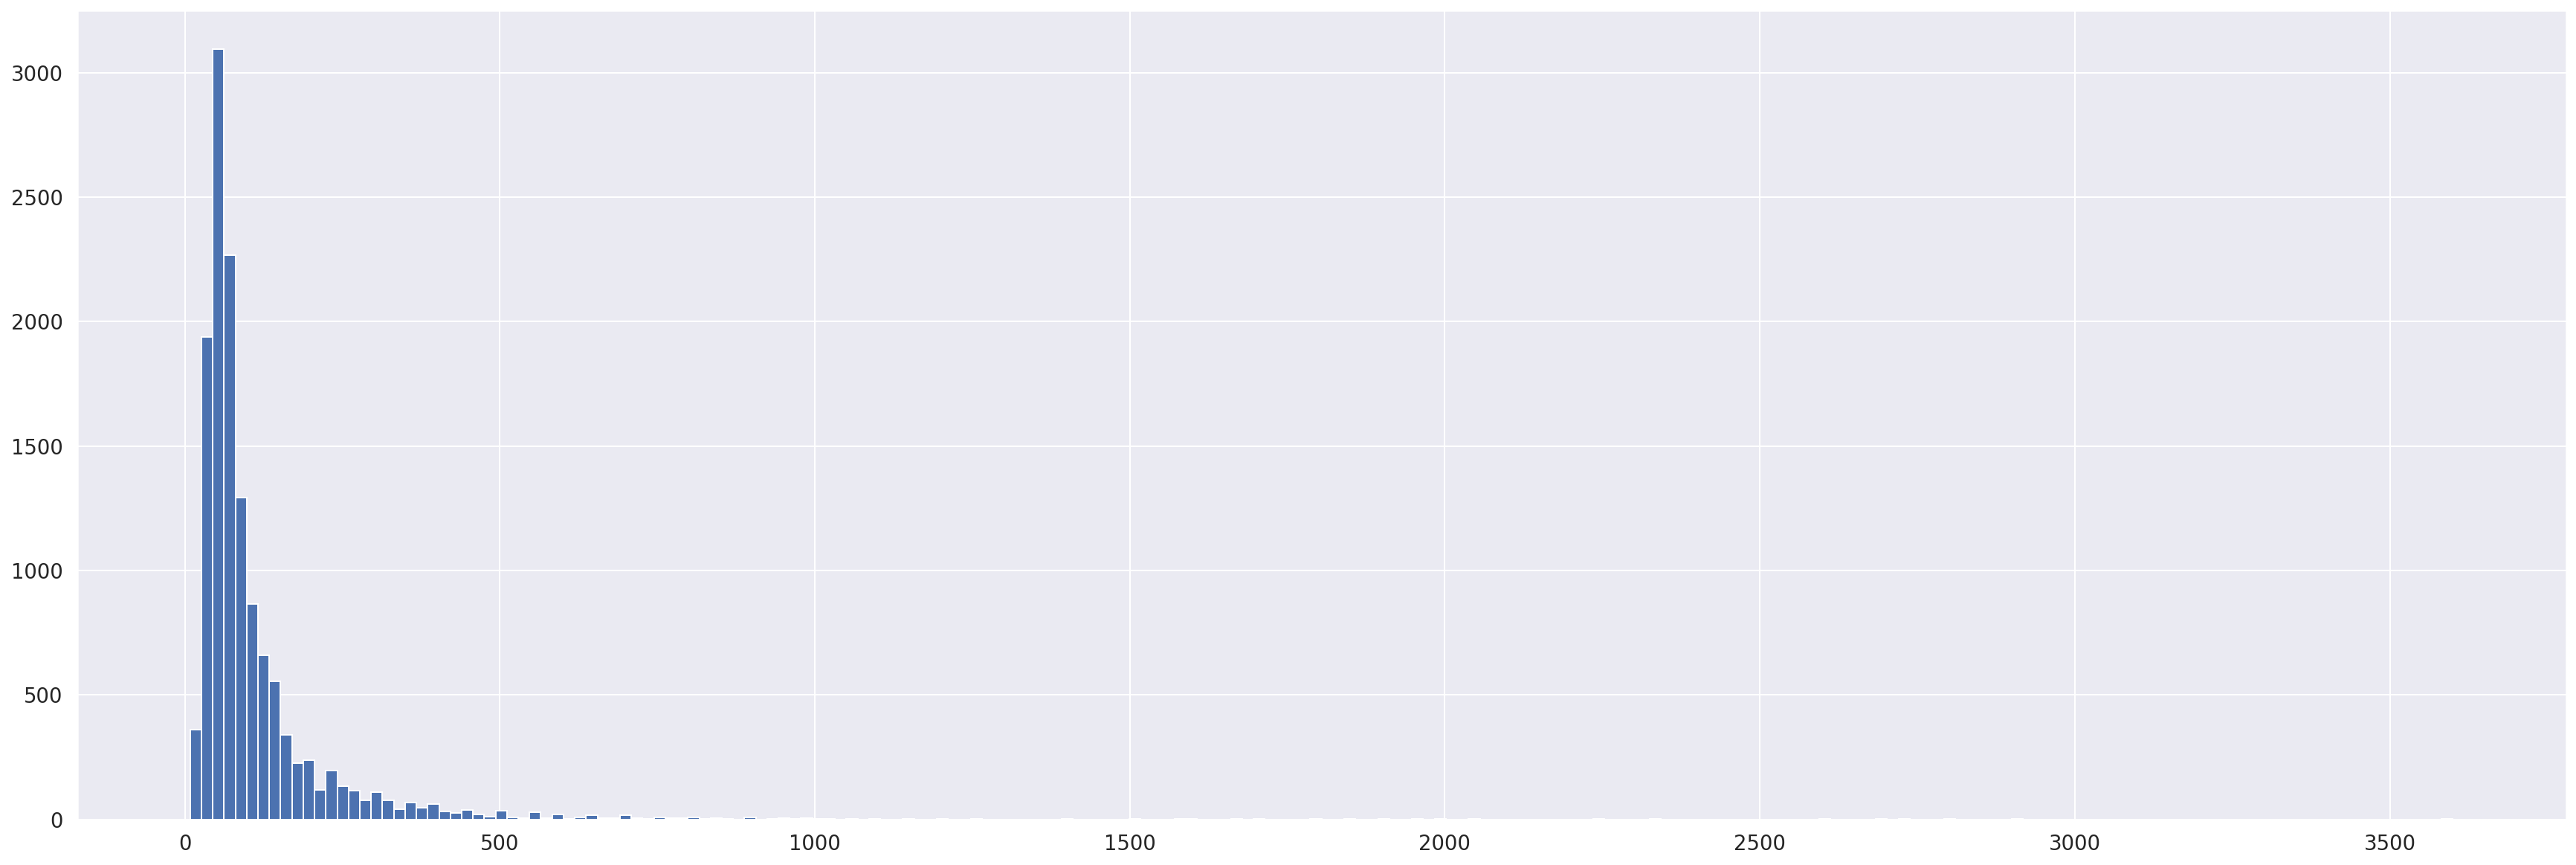

In [ ]:
plt.figure(figsize=(30,10))
(train_df['price']).hist(bins=200)
plt.show()

Here also, the distribution is right skewed.

<Figure size 2160x720 with 0 Axes>

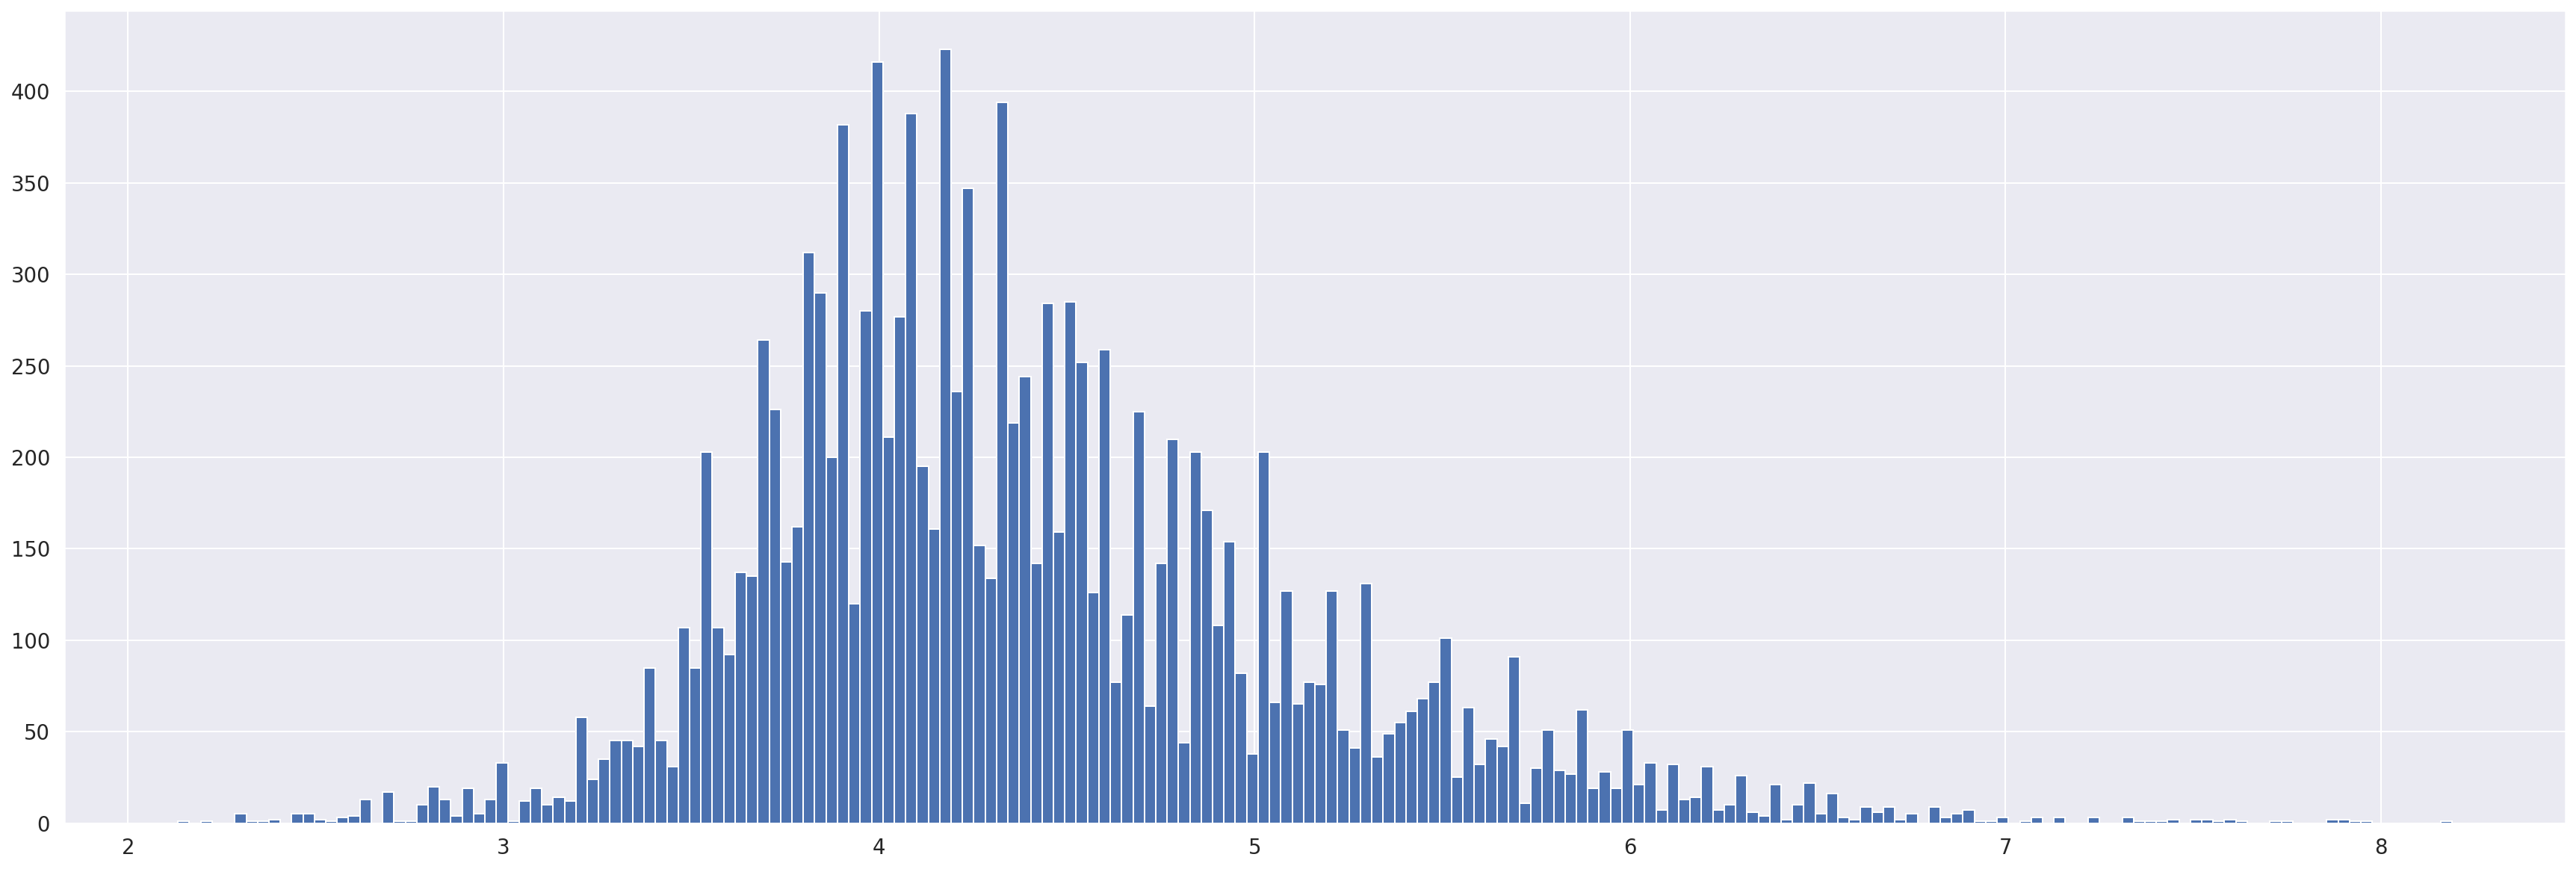

In [ ]:
plt.figure(figsize=(30,10))
np.log(train_df['price']).hist(bins=200)
plt.show()

In [ ]:
train_df['price'] = np.log(train_df['price'])

In [ ]:
train_df.dtypes

area_type            category
availability            int64
size                  float64
society                 int64
total_sqft            float64
bath                  float64
balcony               float64
avg_price_per_loc     float64
price                 float64
dtype: object

# One-Hot Encoding

In [ ]:
main_train = pd.get_dummies(train_df)
main_test = pd.get_dummies(test_df)

In [ ]:
main_train.head(3)

main_test.head(3)

,availability,size,society,total_sqft,bath,balcony,avg_price_per_loc,price,area_type_Built-up Area,area_type_Carpet Area,area_type_Plot Area,area_type_Super built-up Area
0,0,2.0,1,6.962243,2.0,1.0,0.047765,3.665355,0,0,0,1
1,1,4.0,1,7.863267,5.0,3.0,0.047257,4.787492,0,0,1,0
2,1,3.0,0,7.272398,2.0,3.0,0.048929,4.127134,1,0,0,0


,availability,size,society,total_sqft,bath,balcony,avg_price_per_loc,price,area_type_Built-up Area,area_type_Carpet Area,area_type_Plot Area,area_type_Super built-up Area
13256,0,2.0,1,6.962243,2.0,1.0,0.047765,39.07,0,0,0,1
13257,1,4.0,1,7.863267,5.0,3.0,0.047257,120.00,0,0,1,0
13258,1,3.0,0,7.272398,2.0,3.0,0.048929,62.00,1,0,0,0


Saving file post-processing.

In [ ]:
main_train.to_csv('/content/drive/MyDrive/processed/train_df.csv', index=False)
main_test.to_csv('/content/drive/MyDrive/processed/test_df.csv', index=False)

# Modeling

## Import Models

In [ ]:
# Accuracy and Cross-Validation scores.
#Import models from scikit learn module:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score   #For K-fold cross validation
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import datasets, linear_model, metrics
from sklearn import model_selection
from sklearn.metrics import mean_squared_error, make_scorer
from math import sqrt
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last"

import warnings
warnings.filterwarnings('ignore')

In [ ]:
#read it back
main_train=pd.read_csv("/content/drive/MyDrive/processed/train_df.csv")
main_test=pd.read_csv("/content/drive/MyDrive/processed/test_df.csv")

In [ ]:
X = main_train.drop('price', axis=1)
Y = main_train['price']

## Train-Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(10604, 11) (10604,)
(2652, 11) (2652,)


## Creating Custom Metric Function

In [ ]:


def mean_sq_error(y,y_pred):
    return sqrt(mean_squared_error(y,y_pred=y_pred))

rmse = make_scorer(mean_sq_error)


def regression_model(model, data, predictors, outcome):
    scores = cross_val_score(model, data[predictors],data[outcome],cv=5,scoring=rmse)
    for i in range(len(scores)):
        print("CV %s"%i + " Score:%s"%"{0:.5}".format(scores[i]) )
        
    print ("Average RMSE Cross-Validation Score : %s" % "{0:.3}".format(np.mean(scores)))

## Fitting Models

In [ ]:
all_variable=list(main_train)
all_variable.remove('price')

### Decision Tree

In [ ]:
# DecisionTreeRegressor
outcome_var = 'price'
model = DecisionTreeRegressor()
predictor_var = all_variable
regression_model(model, main_train, predictor_var, outcome_var)

CV 0 Score:0.38598
CV 1 Score:0.3907
CV 2 Score:0.39812
CV 3 Score:0.3948
CV 4 Score:0.37587
Average RMSE Cross-Validation Score : 0.389


### Random Forest

In [ ]:
# Random Forest Regression
outcome_var = 'price'
model = RandomForestRegressor(n_estimators=200, random_state=0, n_jobs = -1)
predictor_var = all_variable
regression_model(model, main_train, predictor_var, outcome_var)

CV 0 Score:0.28943
CV 1 Score:0.29558
CV 2 Score:0.30642
CV 3 Score:0.29824
CV 4 Score:0.2905
Average RMSE Cross-Validation Score : 0.296


### XGBoost

In [ ]:
# XGBoost Regressor
outcome_var = 'price'
model = XGBRegressor(n_estimators=540,random_state=0,n_jobs=-1)
predictor_var = all_variable
regression_model(model, main_train, predictor_var, outcome_var)

[05:15:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:15:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:15:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:15:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:15:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CV 0 Score:0.2892
CV 1 Score:0.29383
CV 2 Score:0.30917
CV 3 Score:0.30554
CV 4 Score:0.2946
Average RMSE Cross-Validation Score : 0.298


### LGBM

In [ ]:
# LGBM Regressor
outcome_var = 'price'
model = LGBMRegressor(n_estimators=500)
predictor_var = all_variable
regression_model(model, main_train, predictor_var, outcome_var)

CV 0 Score:0.28578
CV 1 Score:0.29397
CV 2 Score:0.30762
CV 3 Score:0.2996
CV 4 Score:0.28896
Average RMSE Cross-Validation Score : 0.295


We can see that all the ensemble models are giving similar cross validation score of ~0.29 without much hyper parameter tuning.

## Hyper Parameter Tuning

### Randomised Search

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
# Number of trees in random forest
n_estimators = list(np.arange(160,400,100))

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 80, num = 5)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

In [ ]:
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
random_grid

{'bootstrap': [True, False],
 'max_depth': [10, 27, 45, 62, 80, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [160, 260, 360]}

In [ ]:
import time
start = time.clock()

# Use the random grid to search for best hyperparameters
# First create the base model to tune

rf1 = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation,
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator=rf1,
                               param_distributions=random_grid,
                               n_iter=33,
                               cv=3,
                               verbose=5,
                               random_state=0,
                               n_jobs=-1,
                               scoring="neg_mean_squared_error")

# Fit the random search model
rf_random.fit(X, Y)

end = time.clock()
end - start

Fitting 3 folds for each of 33 candidates, totalling 99 fits


6.280715000000001

In [ ]:
def mean_sq_error(y,y_pred):
    return sqrt(mean_squared_error(y,y_pred=y_pred))

rmse = make_scorer(mean_sq_error)


def regression_model(model, data, predictors, outcome):
    scores = cross_val_score(model, data[predictors],data[outcome],cv=5,scoring=rmse)
    for i in range(len(scores)):
        print("CV %s"%i + " Score:%s"%"{0:.5}".format(scores[i]) )
        
    print ("Average RMSE Cross-Validation Score : %s" % "{0:.3}".format(np.mean(scores)))

In [ ]:
# Random Forest Regression
outcome_var = 'price'
model = rf_random.best_estimator_
predictor_var = all_variable
regression_model(model, main_train, predictor_var, outcome_var)

CV 0 Score:0.27675
CV 1 Score:0.28575
CV 2 Score:0.30293
CV 3 Score:0.29254
CV 4 Score:0.28885
Average RMSE Cross-Validation Score : 0.289


In [ ]:
rf1_main=rf_random.best_estimator_
rf1_main.fit(X_train, y_train)

RandomForestRegressor(max_depth=27, max_features='sqrt', min_samples_split=5,
                      n_estimators=260)

In [ ]:
predictions=rf1_main.predict(X_test)

print(np.sqrt(metrics.mean_squared_error(y_test,predictions)))

0.2918647067843223


In [ ]:
estimators = np.arange(200, 930, 40) #850 #880

model=RandomForestRegressor()

rmse_scores = []
for n in estimators:
    model.set_params(bootstrap=True, criterion='mse', max_depth=None,max_features='sqrt', max_leaf_nodes=None)
    model.fit(X_train, y_train)
    predictions=model.predict(X_test)
    rmse_scores.append(np.sqrt(metrics.mean_squared_error(y_test,predictions)))

RandomForestRegressor(criterion='mse', max_features='sqrt')

RandomForestRegressor(criterion='mse', max_features='sqrt')

RandomForestRegressor(criterion='mse', max_features='sqrt')

RandomForestRegressor(criterion='mse', max_features='sqrt')

RandomForestRegressor(criterion='mse', max_features='sqrt')

RandomForestRegressor(criterion='mse', max_features='sqrt')

RandomForestRegressor(criterion='mse', max_features='sqrt')

RandomForestRegressor(criterion='mse', max_features='sqrt')

RandomForestRegressor(criterion='mse', max_features='sqrt')

RandomForestRegressor(criterion='mse', max_features='sqrt')

RandomForestRegressor(criterion='mse', max_features='sqrt')

RandomForestRegressor(criterion='mse', max_features='sqrt')

RandomForestRegressor(criterion='mse', max_features='sqrt')

RandomForestRegressor(criterion='mse', max_features='sqrt')

RandomForestRegressor(criterion='mse', max_features='sqrt')

RandomForestRegressor(criterion='mse', max_features='sqrt')

RandomForestRegressor(criterion='mse', max_features='sqrt')

RandomForestRegressor(criterion='mse', max_features='sqrt')

RandomForestRegressor(criterion='mse', max_features='sqrt')

RandomForestRegressor(criterion='mse', max_features='sqrt')

RandomForestRegressor(criterion='mse', max_features='sqrt')

RandomForestRegressor(criterion='mse', max_features='sqrt')

RandomForestRegressor(criterion='mse', max_features='sqrt')

RandomForestRegressor(criterion='mse', max_features='sqrt')

RandomForestRegressor(criterion='mse', max_features='sqrt')

RandomForestRegressor(criterion='mse', max_features='sqrt')

RandomForestRegressor(criterion='mse', max_features='sqrt')

RandomForestRegressor(criterion='mse', max_features='sqrt')

RandomForestRegressor(criterion='mse', max_features='sqrt')

RandomForestRegressor(criterion='mse', max_features='sqrt')

RandomForestRegressor(criterion='mse', max_features='sqrt')

RandomForestRegressor(criterion='mse', max_features='sqrt')

RandomForestRegressor(criterion='mse', max_features='sqrt')

RandomForestRegressor(criterion='mse', max_features='sqrt')

RandomForestRegressor(criterion='mse', max_features='sqrt')

RandomForestRegressor(criterion='mse', max_features='sqrt')

RandomForestRegressor(criterion='mse', max_features='sqrt')

RandomForestRegressor(criterion='mse', max_features='sqrt')

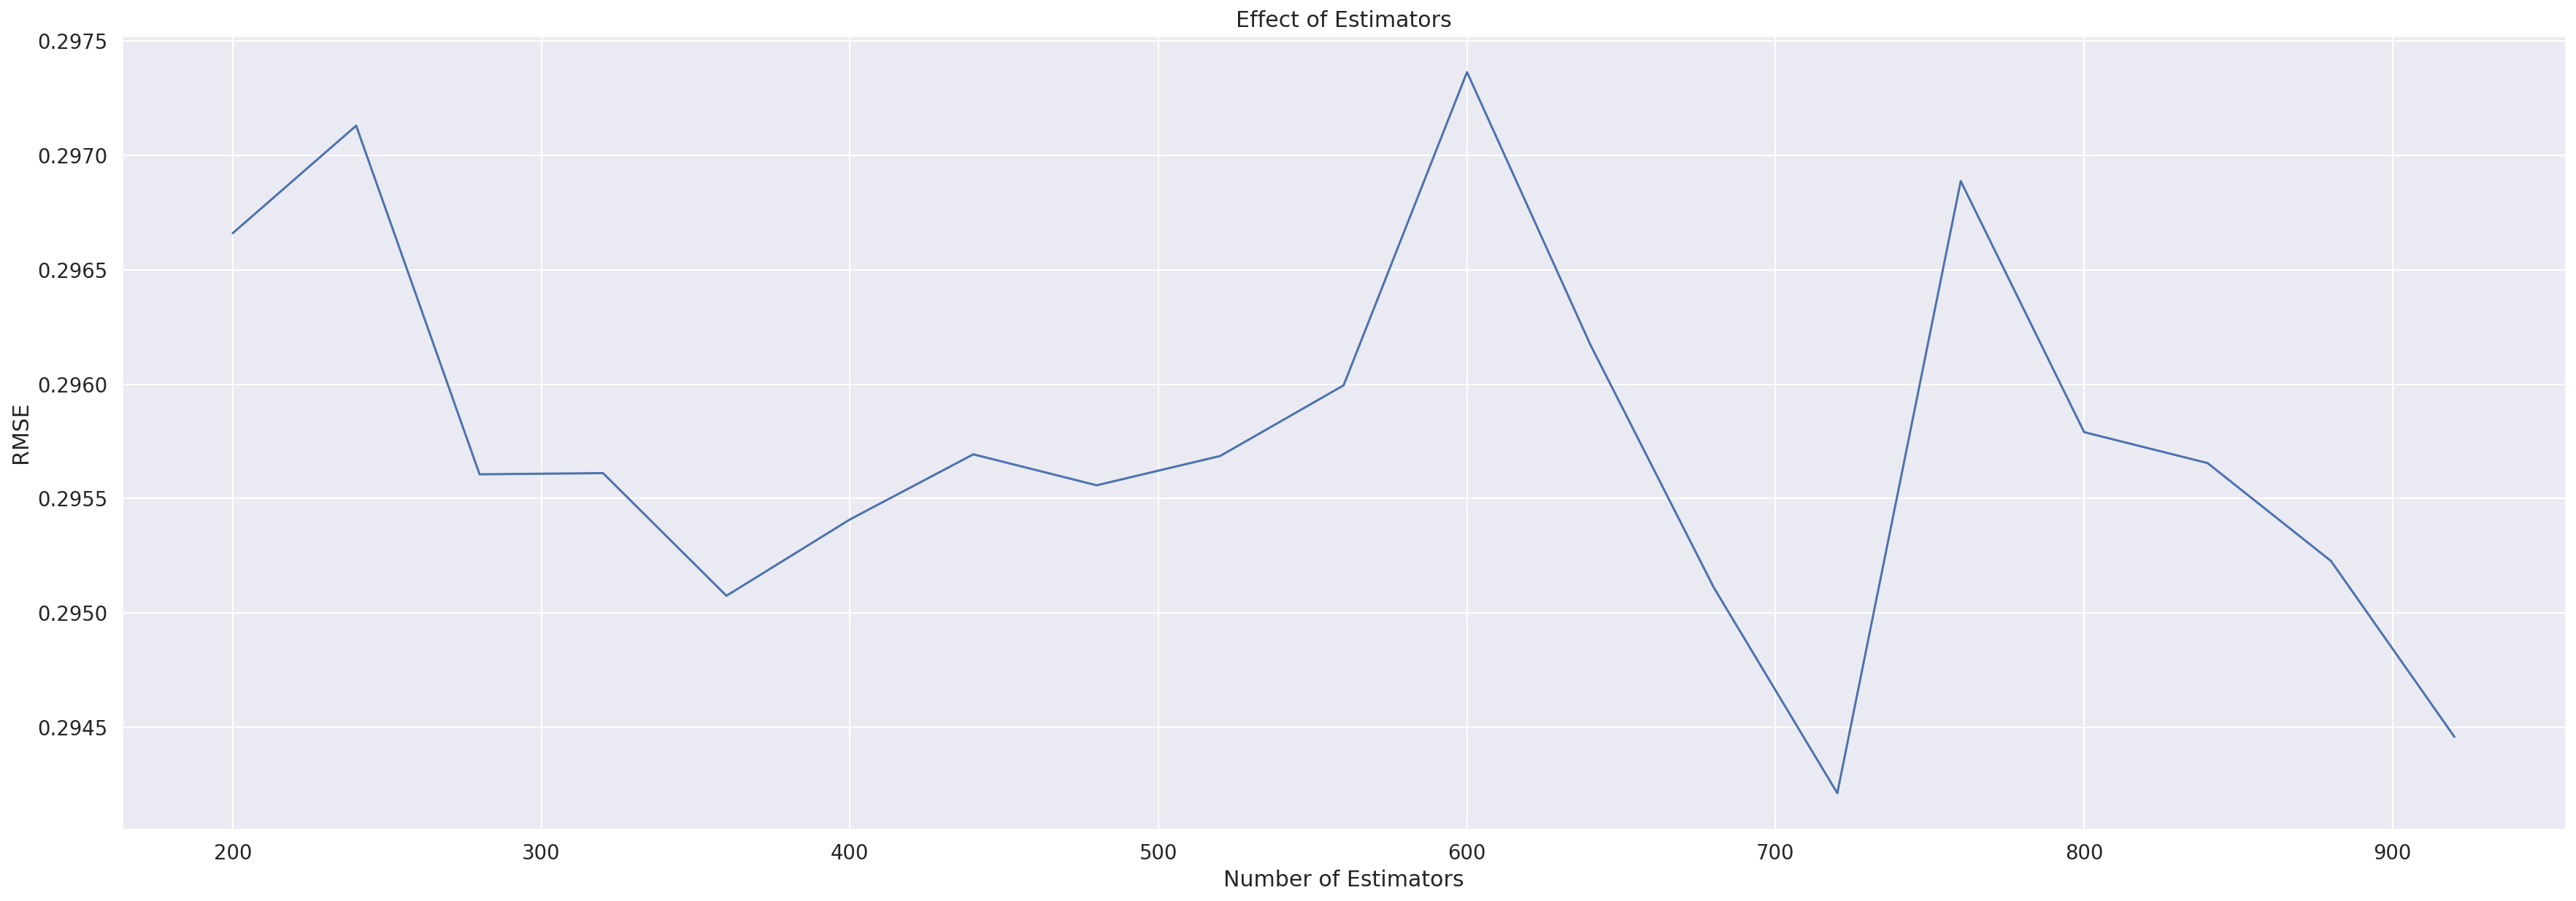

In [ ]:
plt.figure(figsize=(30,10))
plt.title("Effect of Estimators")
plt.xlabel("Number of Estimators")
plt.ylabel("RMSE")
plt.plot(estimators, rmse_scores)

### Grid Search

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
XG_grid = {"learning_rate":[0.01,0.05,0.1],
           "n_estimators":[600],
           "silent":[True],
           "n_jobs":[-1],
           "min_child_weight":[1,3],
           "max_depth":[4,6],
           "booster":['gbtree'],
           "gamma":[0.01,0.1],
           "colsample_bytree":[0.8],
          "subsample":[0.75,0.85]}

In [ ]:
import time
start = time.clock()


XG=XGBRegressor()

XG_Boost = GridSearchCV(estimator=XG,
                        param_grid=XG_grid,
                        n_jobs=-1,
                        cv=4,
                        scoring="neg_mean_squared_error",
                        verbose=5)


XG_Boost.fit(X,Y)

end = time.clock()
end - start

Fitting 4 folds for each of 48 candidates, totalling 192 fits


17.327968999999996

In [ ]:
# cv_results = XG_Boost.cv_results_
# for mean_score, params in zip(cv_results["mean_test_score"], cv_results["params"]):
#     print(np.sqrt(-mean_score), params)

In [ ]:
# XGBoost Regression
rmse = make_scorer(mean_sq_error,greater_is_better=True)
outcome_var = 'price'
model = XG_Boost.best_estimator_
predictor_var = all_variable
regression_model(model, main_train, predictor_var, outcome_var)

CV 0 Score:0.28318
CV 1 Score:0.29064
CV 2 Score:0.30485
CV 3 Score:0.29964
CV 4 Score:0.28903
Average RMSE Cross-Validation Score : 0.293


In [ ]:
# XG_Boost1=XG_Boost.best_estimator_
XG_Boost1 = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                           colsample_bynode=1, colsample_bytree=0.8, gamma=0.01,
                           importance_type='gain', learning_rate=0.05, max_delta_step=0,
                           max_depth=6, min_child_weight=1, missing=None, n_estimators=600,
                           n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
                           reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
                           silent=True, subsample=0.85, verbosity=1)

XG_Boost1.fit(X_train, y_train)

XGBRegressor(colsample_bytree=0.8, gamma=0.01, learning_rate=0.05, max_depth=6,
             n_estimators=600, n_jobs=-1, silent=True, subsample=0.85)

In [ ]:
predictions=XG_Boost1.predict(X_test)

#RMSE
print(np.sqrt(metrics.mean_squared_error(y_test,predictions)))

0.29127071183203757


## Feature Importance

### Random Forest

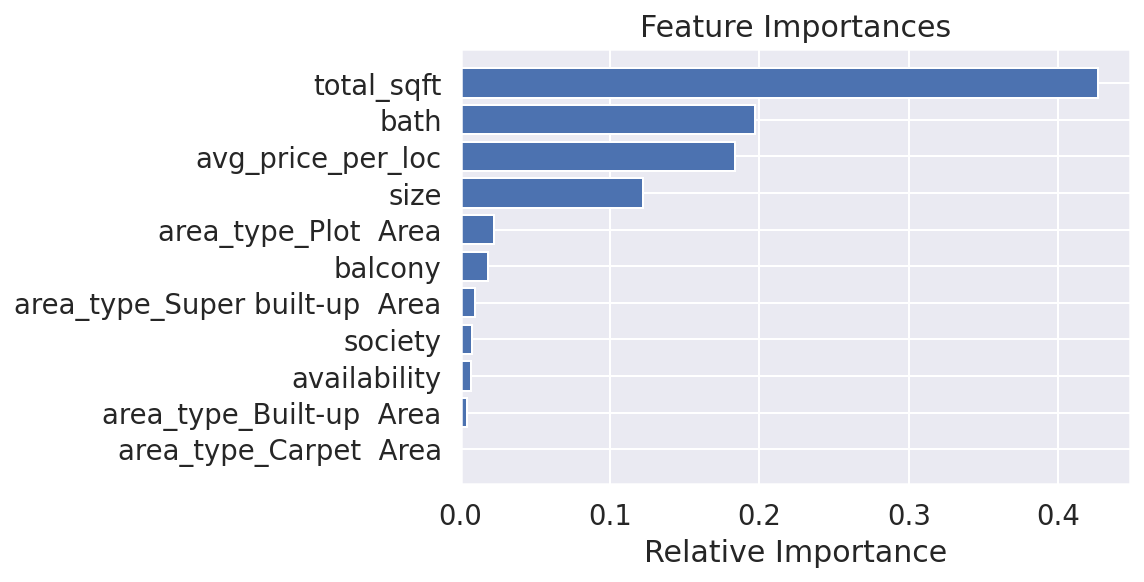

In [ ]:
features = X_train.columns
importances = rf1_main.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### XGBoost

In [ ]:
from xgboost import plot_importance

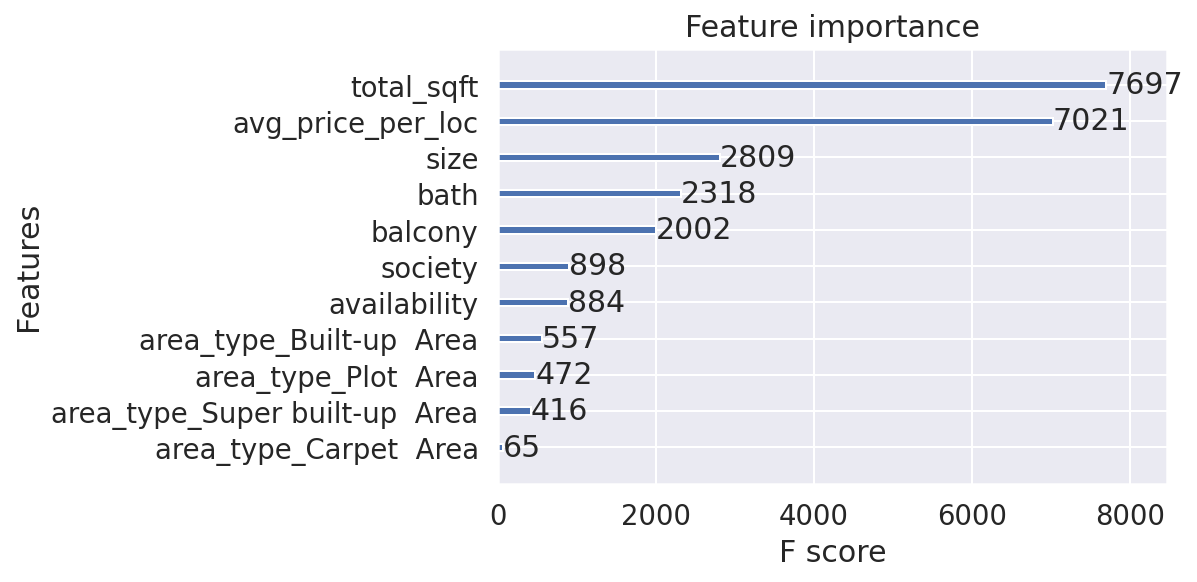

In [ ]:
plot_importance(XG_Boost1)

## Recursive Feature Elimination

In [ ]:
from sklearn.feature_selection import RFECV

### Random Forest

In [ ]:
RFE = RFECV(rf1_main, step=3, cv=3, n_jobs=-1,
            scoring="neg_mean_squared_error", verbose=50)

RFE.fit(X=X_train, y=y_train)

RFECV(cv=3,
      estimator=RandomForestRegressor(max_depth=27, max_features='sqrt',
                                      min_samples_split=5, n_estimators=260),
      n_jobs=-1, scoring='neg_mean_squared_error', step=3, verbose=50)

In [ ]:
RFE.support_

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [ ]:
selected_feature_rf = dict(zip(X_train.columns,RFE.support_))

selected_rf = []
for k,v in selected_feature_rf.items():
    if (v==True):
        selected_rf.append(k)

In [ ]:
selected_rf

['availability',
 'size',
 'society',
 'total_sqft',
 'bath',
 'balcony',
 'avg_price_per_loc',
 'area_type_Built-up  Area',
 'area_type_Carpet  Area',
 'area_type_Plot  Area',
 'area_type_Super built-up  Area']

This means that all the features are contributing to the model.

### XGBoost

In [ ]:
RFE = RFECV(XG_Boost1, step=3, cv=3, n_jobs=-1,
            scoring="neg_mean_squared_error", verbose=50)

RFE.fit(X=X_train, y=y_train)

RFECV(cv=3,
      estimator=XGBRegressor(colsample_bytree=0.8, gamma=0.01,
                             learning_rate=0.05, max_depth=6, n_estimators=600,
                             n_jobs=-1, silent=True, subsample=0.85),
      n_jobs=-1, scoring='neg_mean_squared_error', step=3, verbose=50)

In [ ]:
RFE.support_

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [ ]:
selected_feature_xgb = dict(zip(X_train.columns,RFE.support_))

selected_xgb = []
for k,v in selected_feature_xgb.items():
    if (v==True):
        selected_xgb.append(k)

In [ ]:
selected_xgb

['availability',
 'size',
 'society',
 'total_sqft',
 'bath',
 'balcony',
 'avg_price_per_loc',
 'area_type_Built-up  Area',
 'area_type_Carpet  Area',
 'area_type_Plot  Area',
 'area_type_Super built-up  Area']

This means that all the features are contributing to the model.

# Final Results

In [ ]:
RF = RandomForestRegressor(bootstrap=True,
                           criterion='mse',
                           max_depth=27,
                           max_features='sqrt',
                           max_leaf_nodes=None,
                           min_impurity_decrease=0.0,
                          #  min_impurity_split=None,
                           min_samples_leaf=1,
                           min_samples_split=5,
                           min_weight_fraction_leaf=0.0,
                           n_estimators=260,
                           n_jobs=1,
                           oob_score=False,
                           random_state=None,
                           verbose=0,
                           warm_start=False)

In [ ]:
X_train = main_train.drop('price', axis=1)
y_train = main_train['price']

X_test = main_test.drop('price', axis=1)

In [ ]:
RF.fit(X_train, y_train)

RandomForestRegressor(criterion='mse', max_depth=27, max_features='sqrt',
                      min_samples_split=5, n_estimators=260, n_jobs=1)

In [ ]:
final_predictions = RF.predict(X_test)

In [ ]:
pred_df = pd.DataFrame({'log_price': final_predictions})

pred_df['price'] = pred_df['log_price'].apply(lambda x: 2.71828**x)

pred_df.head()

print(pred_df)

       log_price       price
0       3.690923   40.081715
1       4.896990  133.885735
2       4.209977   67.354788
3       4.549288   94.564783
4       3.921842   50.493242
...          ...         ...
13315   5.508589  246.801749
13316   6.013145  408.765331
13317   3.948183   51.840949
13318   5.994950  401.394815
13319   2.837855   17.079065

[13320 rows x 2 columns]


-----------------------------------------------------End-----------------------------------------------------